
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is yellow line
* Saves Results to text file



## Experimental Details


In [1]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [2]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [3]:

import pandas as pd
import numpy as np


In [4]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [5]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [6]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [7]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [8]:

from einops import rearrange
from math import sqrt, log


In [9]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [10]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [11]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [12]:

device = "cpu"


In [13]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [14]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [15]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [16]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [17]:

pos_emb.shape


torch.Size([15, 512])

In [18]:

res = x_enc + pos_emb


In [19]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [20]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [21]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [22]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [23]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [24]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [25]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [26]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [27]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [28]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

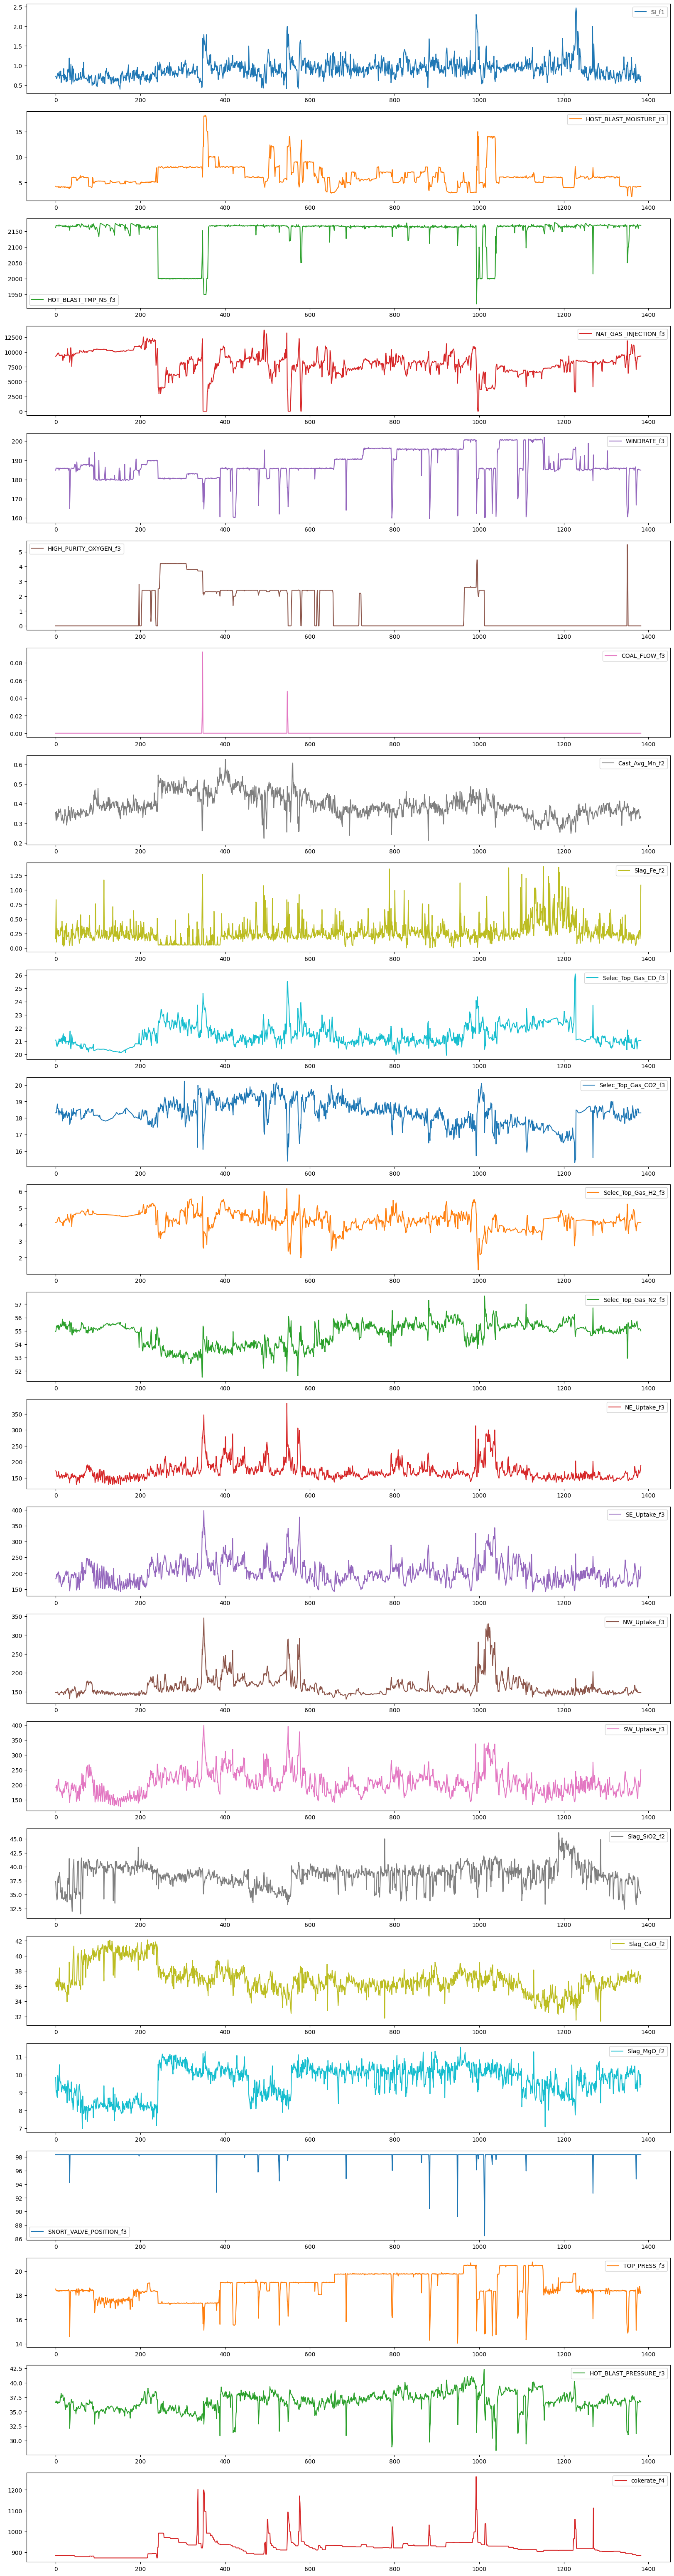

In [29]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [30]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [31]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [32]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [33]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [34]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [35]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [36]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [37]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [38]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [39]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [40]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [41]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [42]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        
        ## self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        ## self.map_permute1 = nn.Linear( 512, 512 )
        ## self.map_permute2 = nn.Linear( 512, 512  )
        ## self.act_permute1 = nn.ReLU()
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15
        
        ## ids and targets are both (B, T) tensors of integers
        ## tok_emb = self.token_embedding_table(idx)  

        idx = self.map_24_512( idx )
        idx = self.map_act(    idx )

        tok_emb = idx       ## (B, 15, 512)
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines
        
        x = tok_emb + pos_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [43]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion       = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E )
        y_train        = yb.view(     B*T, E )

        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [44]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2

comment_exp       = "None"



## Utility Functions


In [45]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [46]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [47]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",  mse_eval_bins.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [48]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [49]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [50]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [51]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [52]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [53]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [54]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [55]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [56]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [57]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [58]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [59]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [60]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [61]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [62]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [63]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [64]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [65]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [66]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [67]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [68]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [69]:

training_chunk = 400


In [70]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [71]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


856

In [72]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
856
1271


In [73]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [74]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
856  -0.056293   -0.005580                6.027210          2163.478631   
857   0.018595    0.001037                5.985443          2163.743620   
858  -0.102992   -0.019010                6.074585          2162.990305   
859   0.218379   -0.009642                6.127090          2166.137984   
860  -0.029266   -0.017196                6.051209          2163.590108   
...        ...         ...                     ...                  ...   
1266 -0.101000    0.018717                5.905406          2167.595059   
1267  0.077042    0.026137                5.936214          2167.038762   
1268  1.116388    0.138056                5.972157          2166.389749   
1269 -1.167763    0.006450                7.926798          2014.860631   
1270  0.129889    0.015356                6.150715          2161.359662   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
856             8392.478019   195.765204                    0.0           0.0   
857             8333.684279   195.741554                    0.0           0.0   
858             8211.829933   195.821675                    0.0           0.0   
859             8254.430745   195.041371                    0.0           0.0   
860             8596.791491   195.749925                    0.0           0.0   
...                     ...          ...                    ...           ...   
1266            8246.341484   185.193404                    0.0           0.0   
1267            8336.906828   184.939374                    0.0           0.0   
1268            8291.548361   185.511249                    0.0           0.0   
1269            4143.603089   179.251579                    0.0           0.0   
1270            8285.237778   192.846549                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
856            0.368        0.22            21.008759             18.155376   
857            0.371        0.19            21.069566             18.062625   
858            0.366        0.18            21.007137             18.270251   
859            0.346        0.30            21.129016             18.174347   
860            0.393        0.26            20.824775             18.023294   
...              ...         ...                  ...                   ...   
1266           0.348        0.28            21.318634             18.423311   
1267           0.359        0.20            21.305278             18.432437   
1268           0.352        0.20            21.289695             18.443084   
1269           0.321        0.21            23.717963             15.602264   
1270           0.322        0.17            21.271886             18.455251   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
856              4.203611            55.218230    167.761929    193.963549   
857              4.173722            55.298827    159.936991    195.327091   
858              4.141309            55.303829    163.987423    208.691498   
859              4.226704            55.274610    170.463418    207.361336   
860              4.290026            55.668006    185.733977    220.560018   
...                   ...                  ...           ...           ...   
1266             4.239088            54.665657    157.378155    215.224707   
1267             4.237632            54.657850    143.536396    191.564102   
1268             4.235934            54.750682    153.695019    192.347016   
1269             3.323592            56.721370    201.874585    253.280100   
1270             4.233992            54.771566    161.185627    209.286934   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
856     152.937115    212.262296     38.580002    36.619999        10.20   
857     152.073157    214.093886     39.259998    36.459999        10.13   
858     150.707080


## Train and test


In [75]:

n = block_size

print( n )


15


In [76]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [77]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [78]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
1256 -0.081233   -0.014983                6.183475          2168.271670   
1257  0.002833   -0.026125                6.043982          2167.265824   
1258 -0.002800   -0.018855                5.775629          2166.431161   
1259  0.148300    0.004930                5.613939          2164.344538   
1260  0.040833   -0.017233                5.643540          2169.601519   
1261  0.052833    0.005817                5.669213          2170.749453   
1262  0.111333    0.016167                5.715425          2171.022618   
1263 -0.215700   -0.018753                5.756502          2170.283828   
1264  0.040771    0.011590                5.812983          2169.263950   
1265  0.109762    0.020693                5.868730          2168.257317   
1266 -0.101000    0.018717                5.905406          2167.595059   
1267  0.077042    0.026137                5.936214          2167.038762   
1268  1.116388    0.138056                5.972157          2166.389749   
1269 -1.167763    0.006450                7.926798          2014.860631   
1270  0.129889    0.015356                6.150715          2161.359662   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
1256            8363.420745   184.953951                    0.0           0.0   
1257            8274.276402   185.460198                    0.0           0.0   
1258            8261.179691   198.922001                    0.0           0.0   
1259            8262.648661   185.401710                    0.0           0.0   
1260            8241.632988   185.125443                    0.0           0.0   
1261            8299.167014   184.958402                    0.0           0.0   
1262            8274.989070   185.071369                    0.0           0.0   
1263            8274.723531   184.881665                    0.0           0.0   
1264            8290.689288   184.812175                    0.0           0.0   
1265            8284.398318   185.168091                    0.0           0.0   
1266            8246.341484   185.193404                    0.0           0.0   
1267            8336.906828   184.939374                    0.0           0.0   
1268            8291.548361   185.511249                    0.0           0.0   
1269            4143.603089   179.251579                    0.0           0.0   
1270            8285.237778   192.846549                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
1256           0.328        0.24            21.124130             18.639349   
1257           0.310        0.17            21.130643             18.657520   
1258           0.294        0.25            21.134714             18.668877   
1259           0.307        0.36            21.140413             18.684777   
1260           0.357        0.28            21.146112             18.700677   
1261           0.360        0.29            21.150183             18.712034   
1262           0.384        0.21            21.159917             18.699724   
1263           0.366        0.16            21.247855             18.592880   
1264           0.361        0.10            21.358705             18.395934   
1265           0.354        0.22            21.334535             18.412447   
1266           0.348        0.28            21.318634             18.423311   
1267           0.359        0.20            21.305278             18.432437   
1268           0.352        0.20            21.289695             18.443084   
1269           0.321        0.21            23.717963             15.602264   
1270           0.322        0.17            21.271886             18.455251   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
1256             4.258016            54.954069    149.292724    192.570261   
1257             4.256075            54.935553    156.087268    191.353025   
1258     

In [79]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [80]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.0508216619491577
500 train loss =  0.03444809466600418
1000 train loss =  0.011269977316260338
1500 train loss =  0.007483051158487797
2000 train loss =  0.005111695732921362
2500 train loss =  0.003951787482947111


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


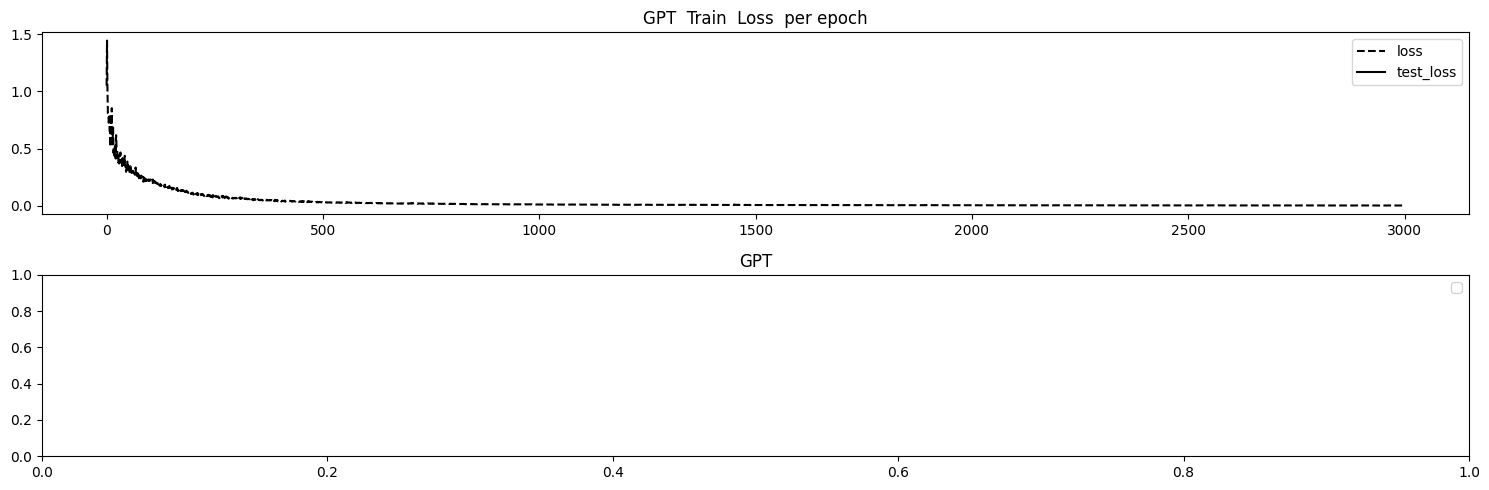

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.17352108657360077
mae, mse, rmse, mape, mspe, rse, corr
(0.26076987, 0.1735211, 0.41655865, 6.7861257, 228.46127, 1.0784676)
Testing R**2 - SI only:  -0.16309248613744254
Testing R**2 - SI only:  -0.16309248613744254
Testing R**2 - All features:  0.9849953133846685


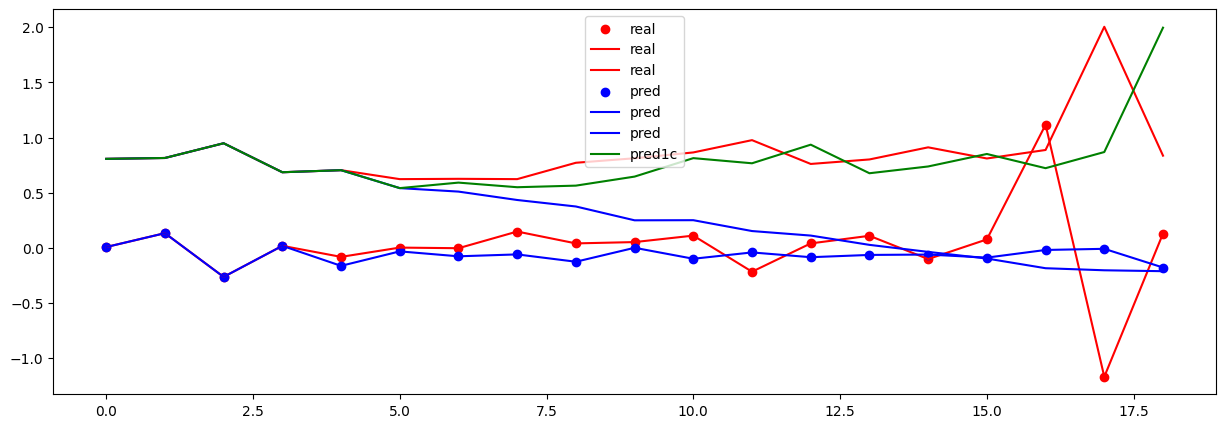

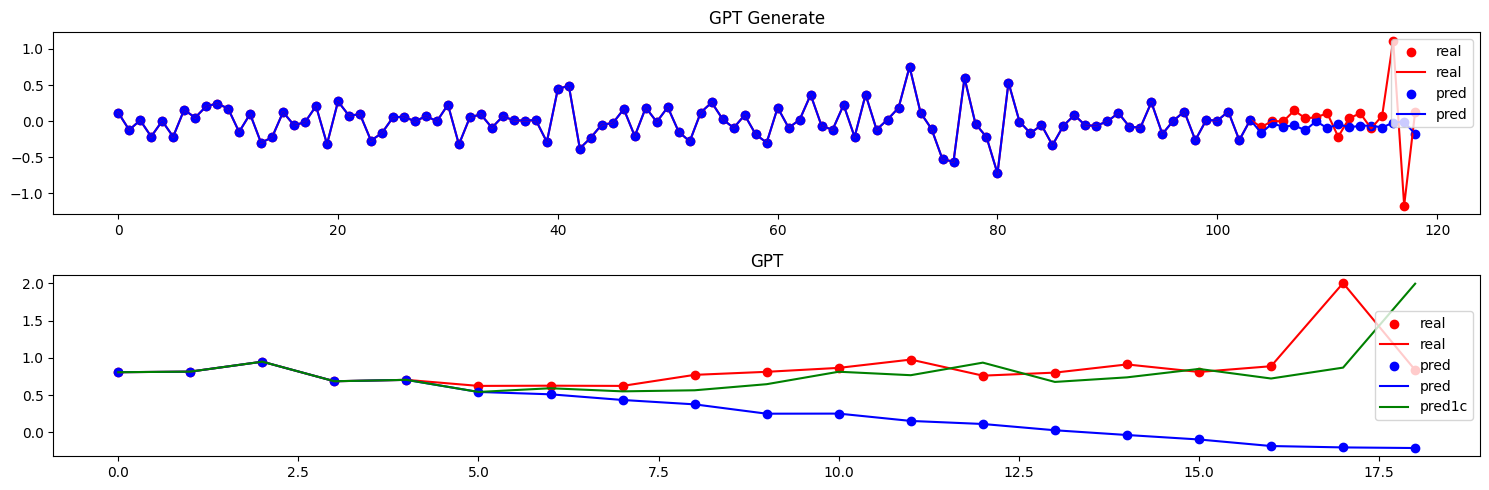

In [81]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.4780104160308838
500 train loss =  0.07579397410154343
1000 train loss =  0.02708778902888298
1500 train loss =  0.013618041761219501
2000 train loss =  0.00844539050012827
2500 train loss =  0.0062730866484344006


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


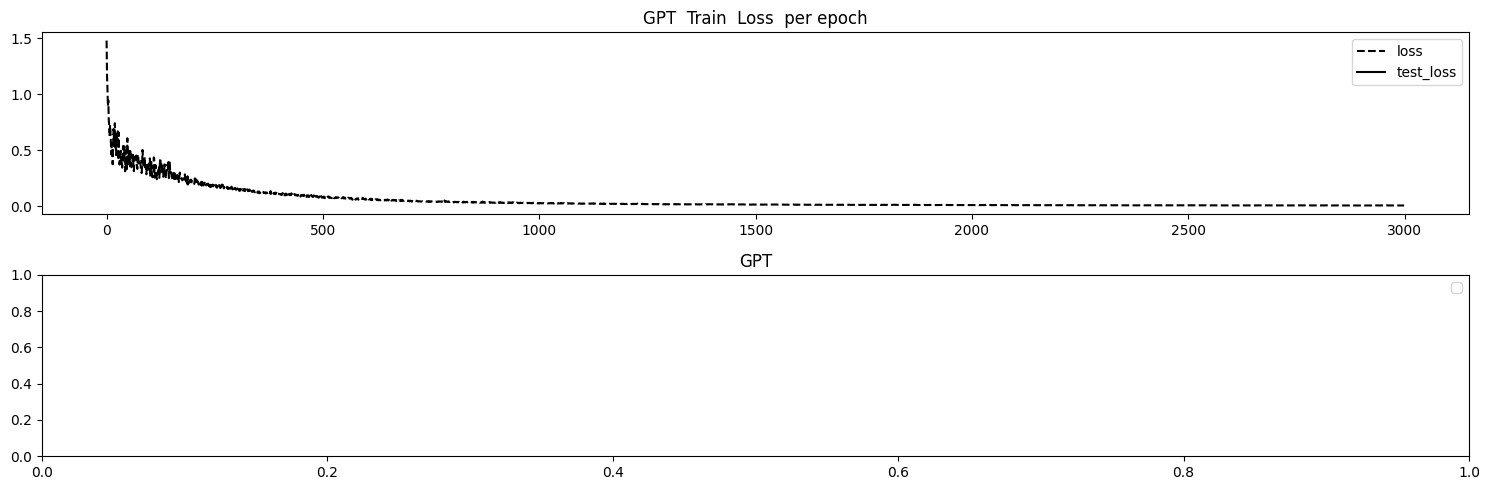

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.15831708908081055
mae, mse, rmse, mape, mspe, rse, corr
(0.23497093, 0.15831709, 0.3978908, 4.1083283, 69.759315, 1.0301367)
Testing R**2 - SI only:  -0.06118172306435965
Testing R**2 - SI only:  -0.06118172306435965
Testing R**2 - All features:  0.984828994292511


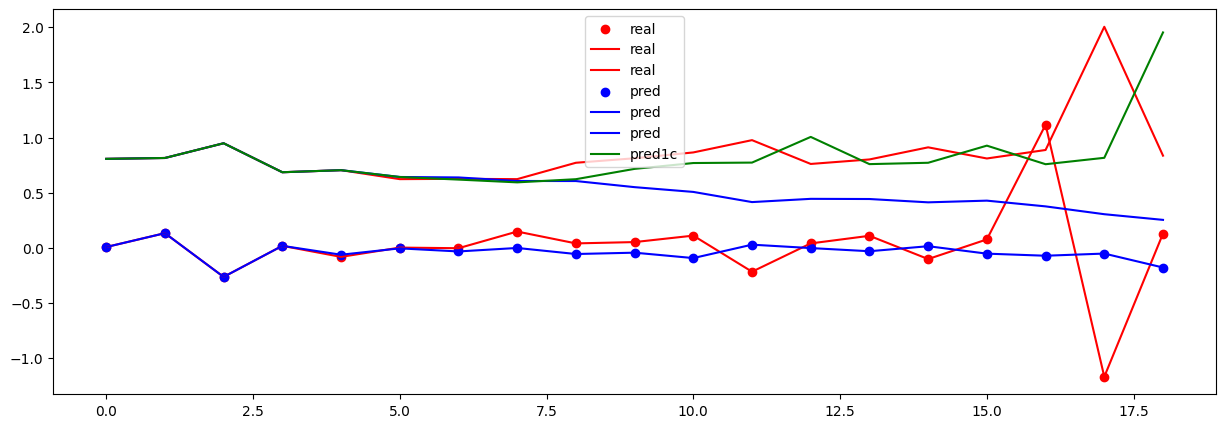

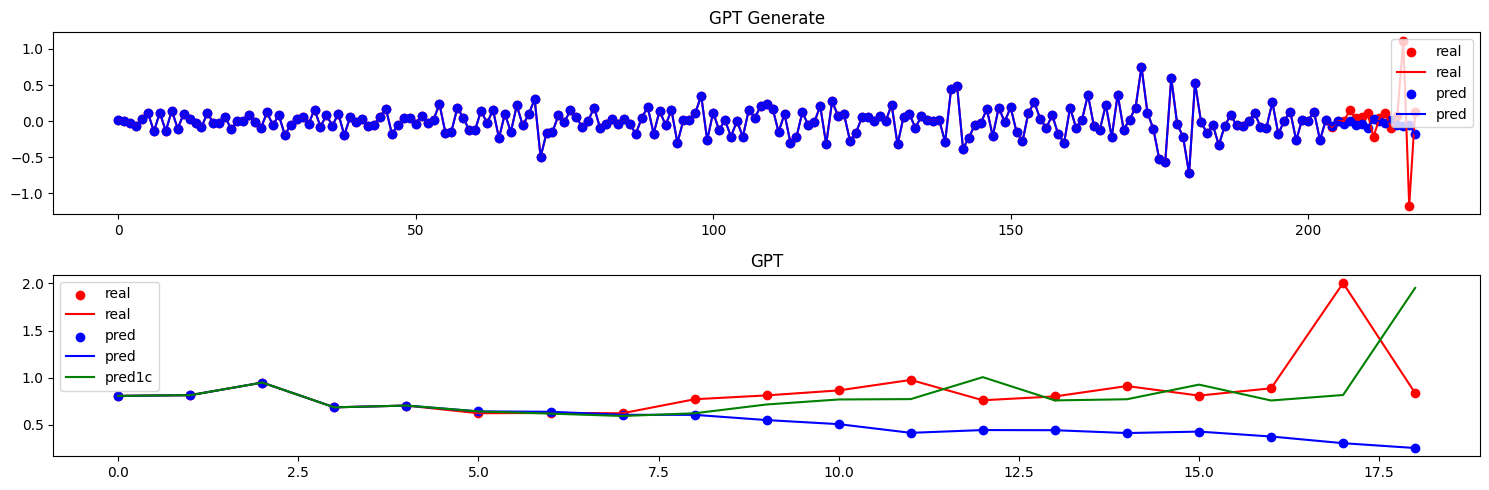

In [82]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.1272457838058472
500 train loss =  0.12791754305362701
1000 train loss =  0.04542414844036102
1500 train loss =  0.023398833349347115
2000 train loss =  0.012712826952338219
2500 train loss =  0.008977167308330536


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


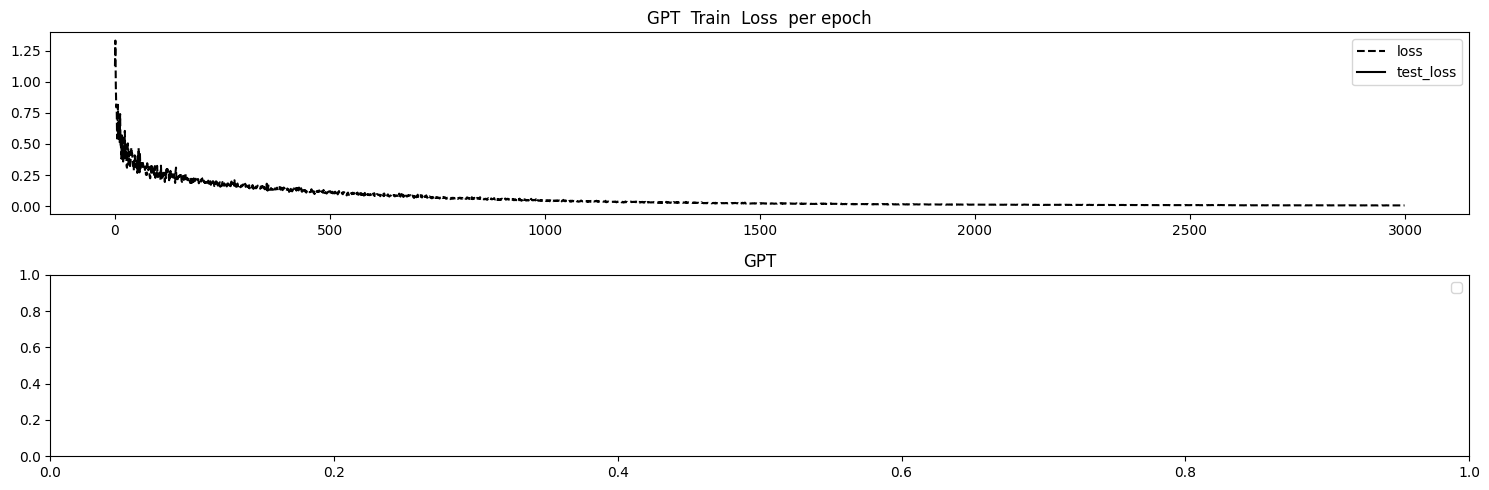

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.1393243968486786
mae, mse, rmse, mape, mspe, rse, corr
(0.20843498, 0.1393244, 0.37326184, 4.2501097, 90.59706, 0.9663725)
Testing R**2 - SI only:  0.06612416042589786
Testing R**2 - SI only:  0.06612416042589786
Testing R**2 - All features:  0.9895602704358566


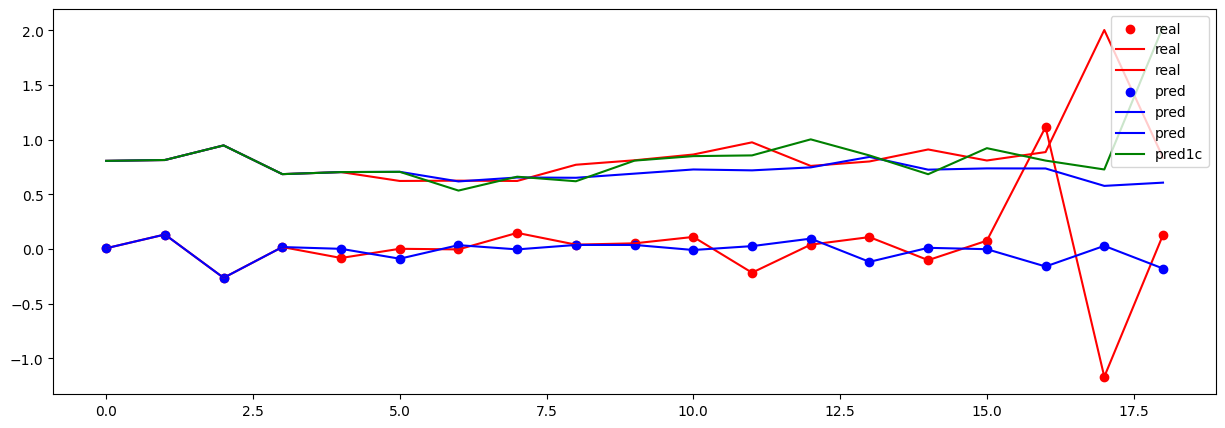

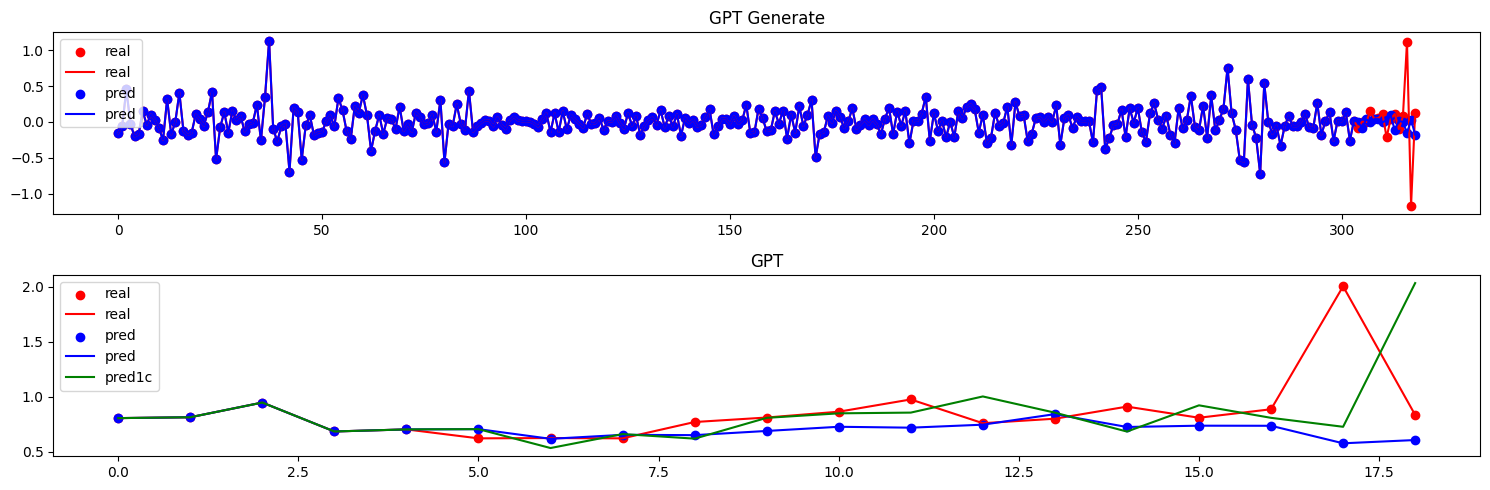

In [83]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.4517017602920532
500 train loss =  0.1358414739370346
1000 train loss =  0.060544203966856
1500 train loss =  0.030965758487582207
2000 train loss =  0.01653103344142437
2500 train loss =  0.01052124984562397


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


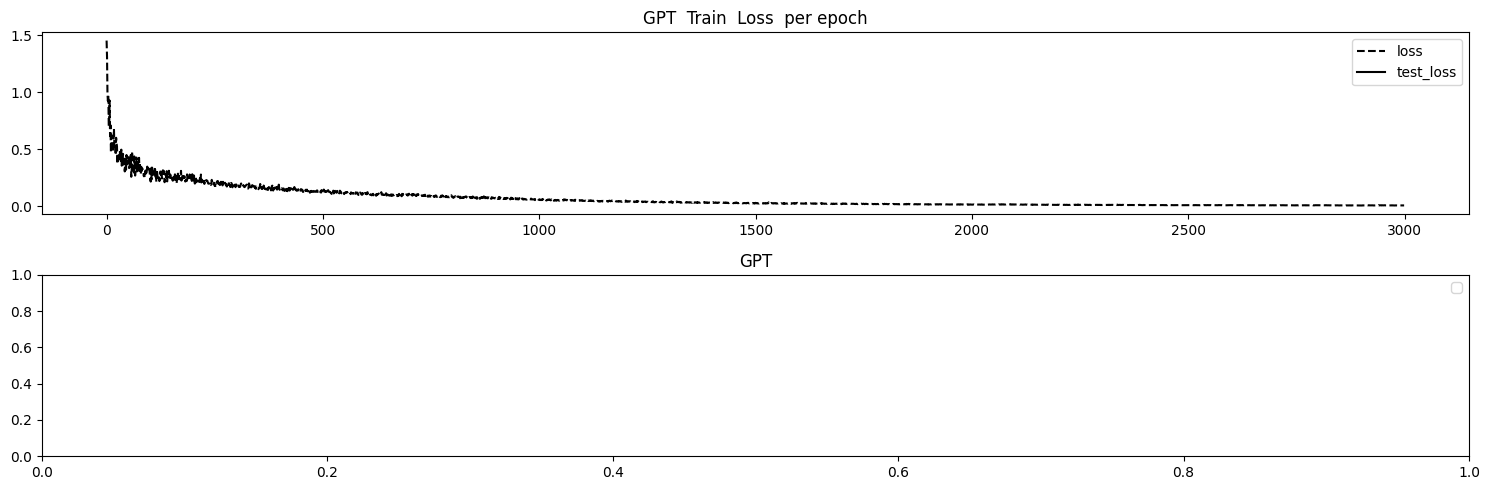

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.15728867053985596
mae, mse, rmse, mape, mspe, rse, corr
(0.2309841, 0.15728867, 0.39659634, 3.4208314, 45.7211, 1.0267855)
Testing R**2 - SI only:  -0.05428832364831937
Testing R**2 - SI only:  -0.05428832364831937
Testing R**2 - All features:  0.9861546042768295


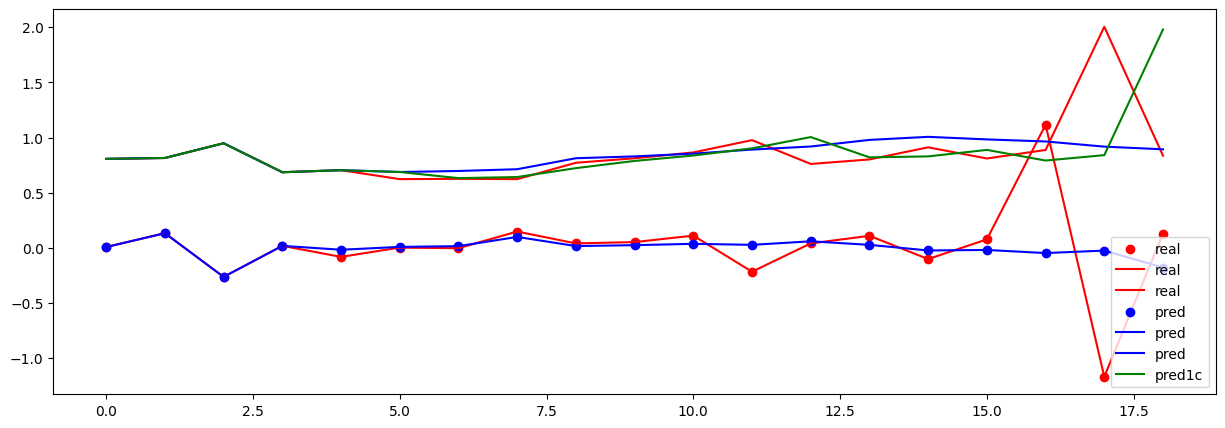

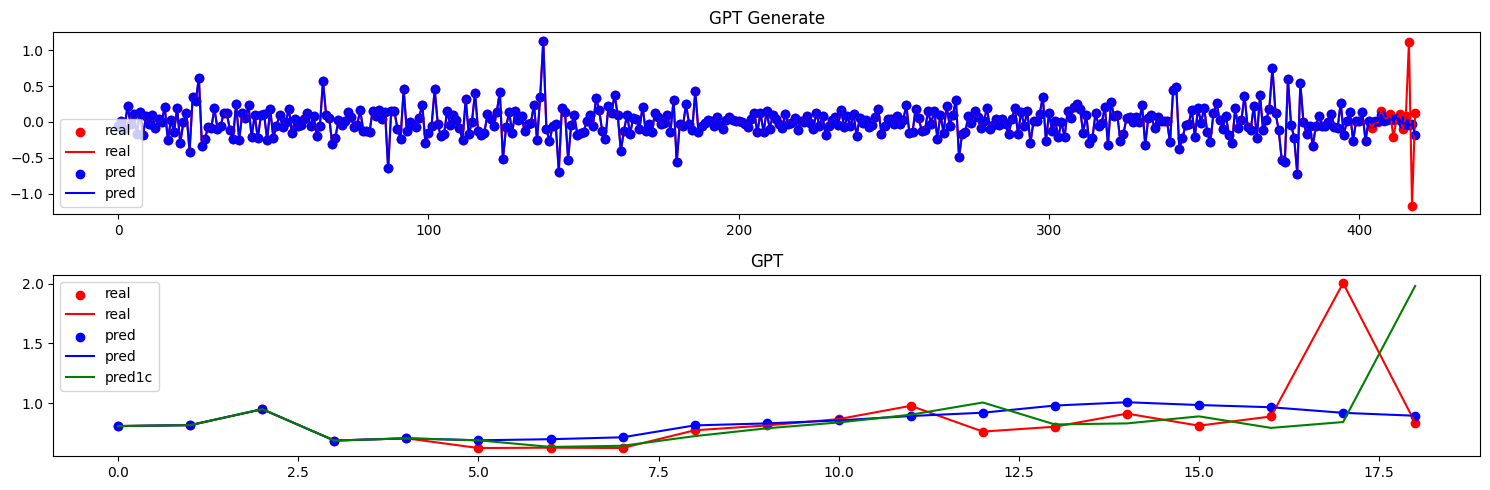

In [84]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [85]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
769
1184
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.3216843605041504
500 train loss =  0.03295474499464035
1000 train loss =  0.011527915485203266
1500 train loss =  0.007878521457314491
2000 train loss =  0.0050806161016225815
2500 train loss =  0.0039528231136500835


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


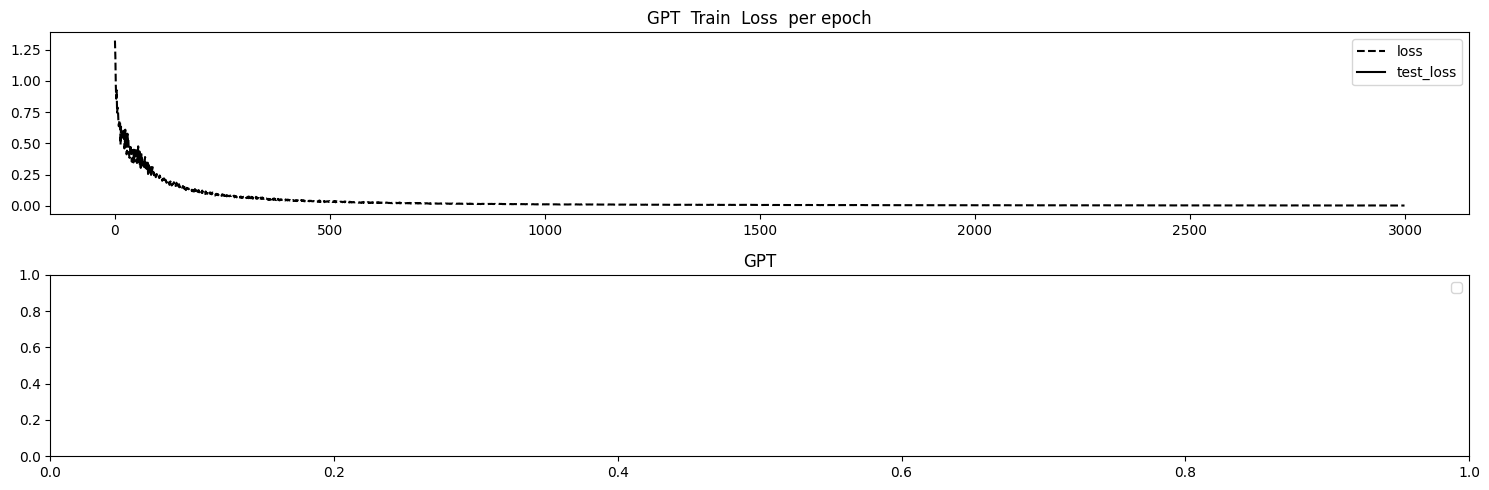

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05557514354586601
mae, mse, rmse, mape, mspe, rse, corr
(0.19134007, 0.05557515, 0.23574382, 1.9830358, 11.901853, 1.3025165)
Testing R**2 - SI only:  -0.6965492315105011
Testing R**2 - SI only:  -0.6965492315105011
Testing R**2 - All features:  0.9987675805476723


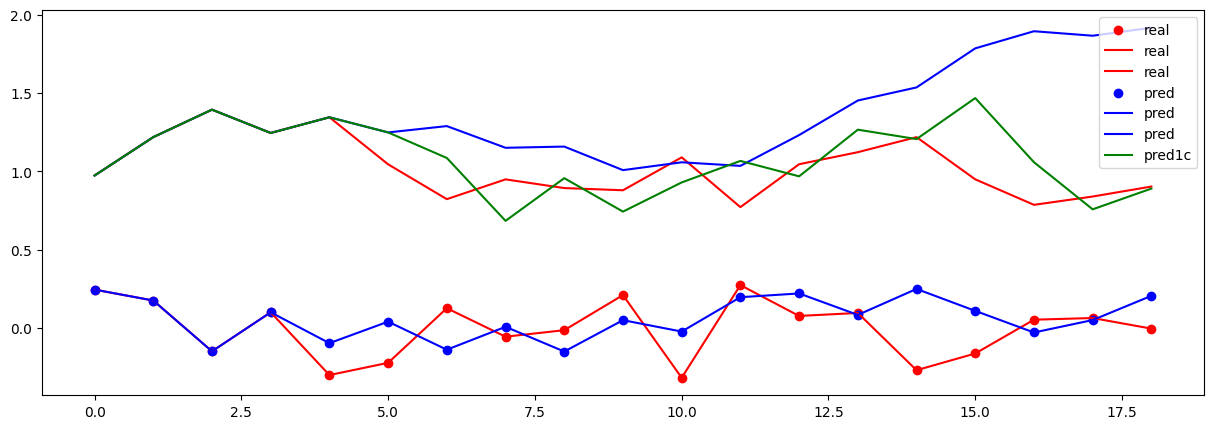

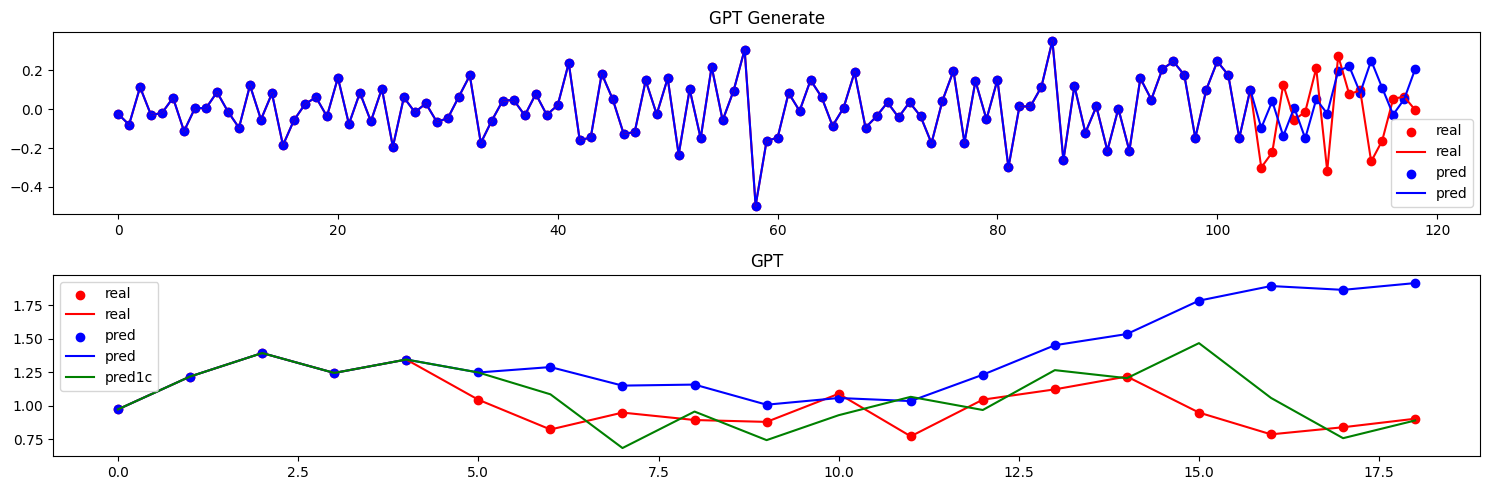

In [86]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([200, 25])
0 train loss =  1.2025341987609863
500 train loss =  0.08013809472322464
1000 train loss =  0.03022129088640213
1500 train loss =  0.0145812863484025
2000 train loss =  0.008827638812363148
2500 train loss =  0.005980559159070253


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


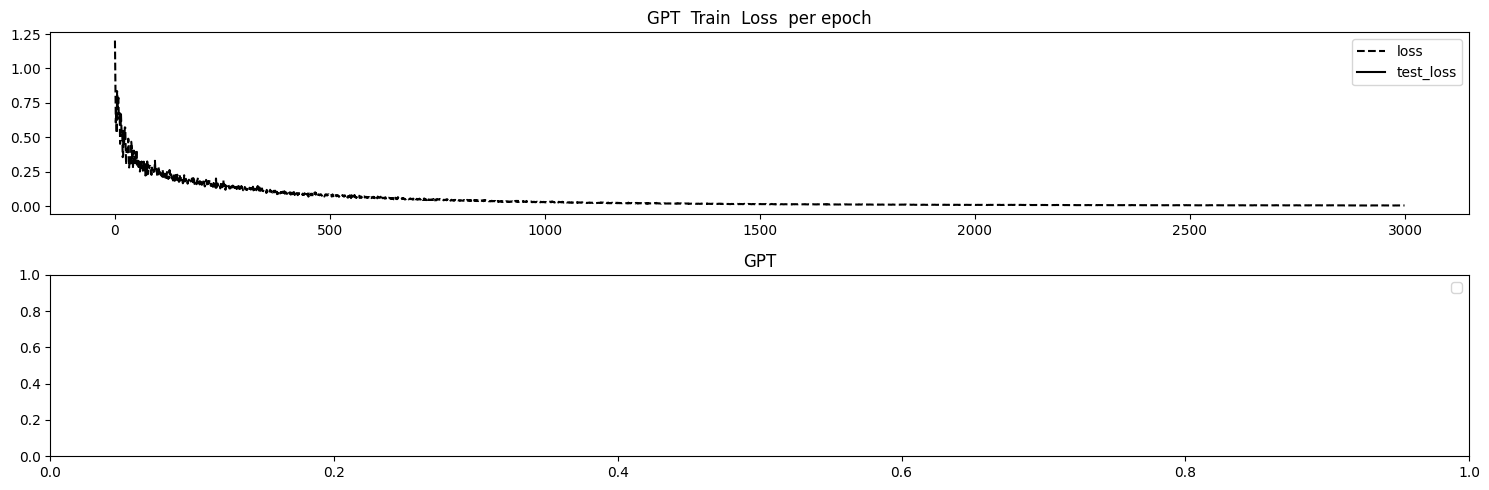

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.047827284783124924
mae, mse, rmse, mape, mspe, rse, corr
(0.17675507, 0.047827285, 0.21869451, 1.3258505, 2.2736423, 1.2083167)
Testing R**2 - SI only:  -0.46002930562730904
Testing R**2 - SI only:  -0.46002930562730904
Testing R**2 - All features:  0.9984068919331623


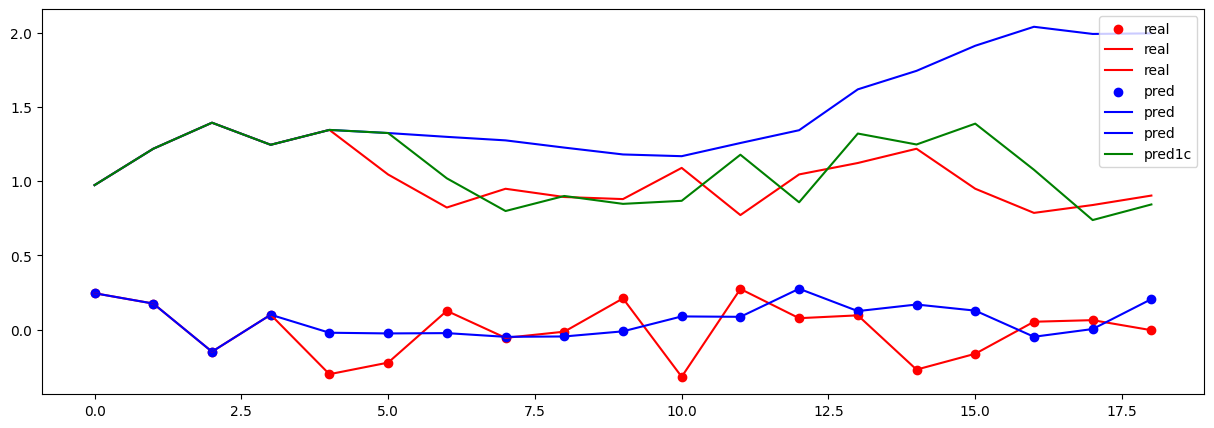

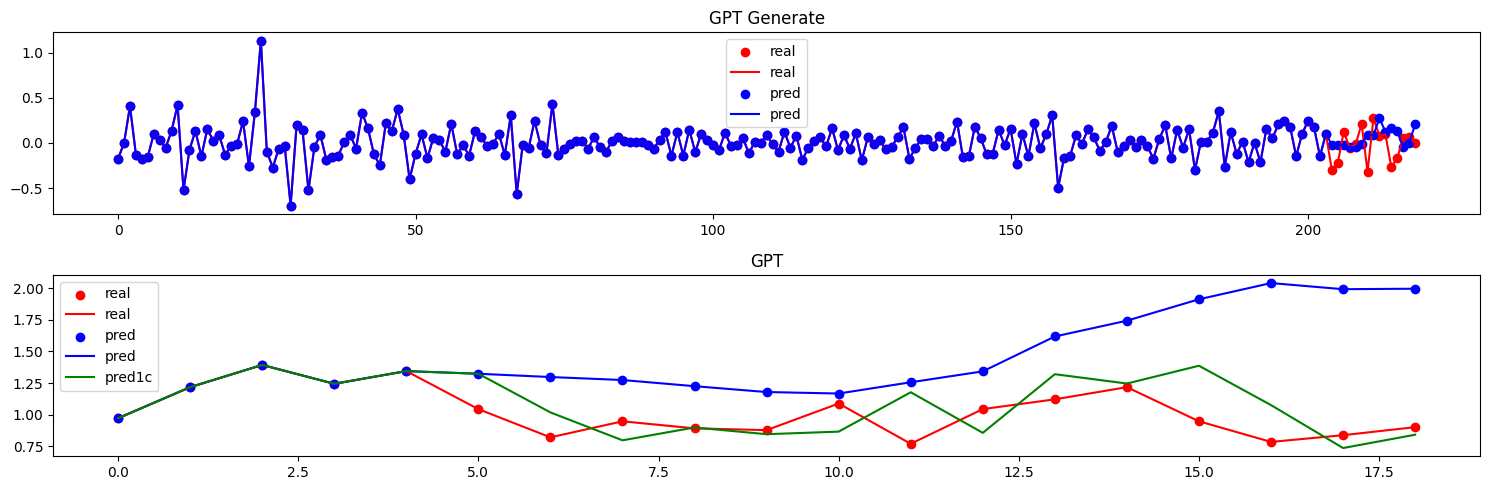

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([300, 25])
0 train loss =  1.3159573078155518
500 train loss =  0.10289353132247925
1000 train loss =  0.048777710646390915
1500 train loss =  0.02302277646958828
2000 train loss =  0.011536465026438236
2500 train loss =  0.00857613980770111


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


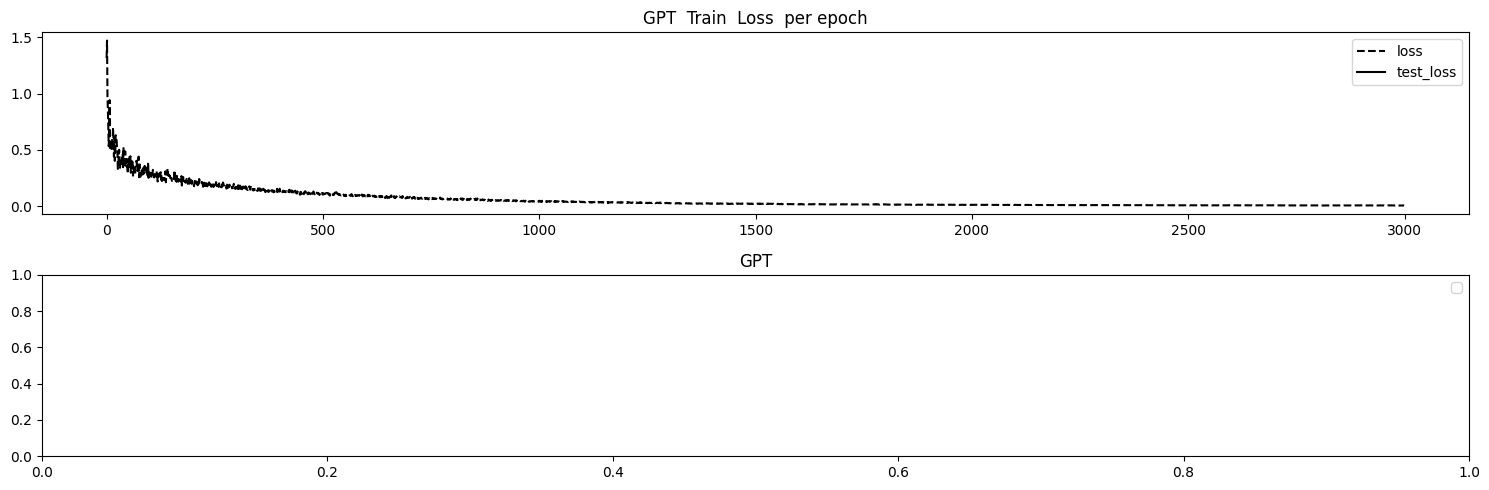

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05601939931511879
mae, mse, rmse, mape, mspe, rse, corr
(0.19008619, 0.056019407, 0.23668419, 1.9597813, 8.073751, 1.3077122)
Testing R**2 - SI only:  -0.7101111813962422
Testing R**2 - SI only:  -0.7101111813962422
Testing R**2 - All features:  0.9979210915276638


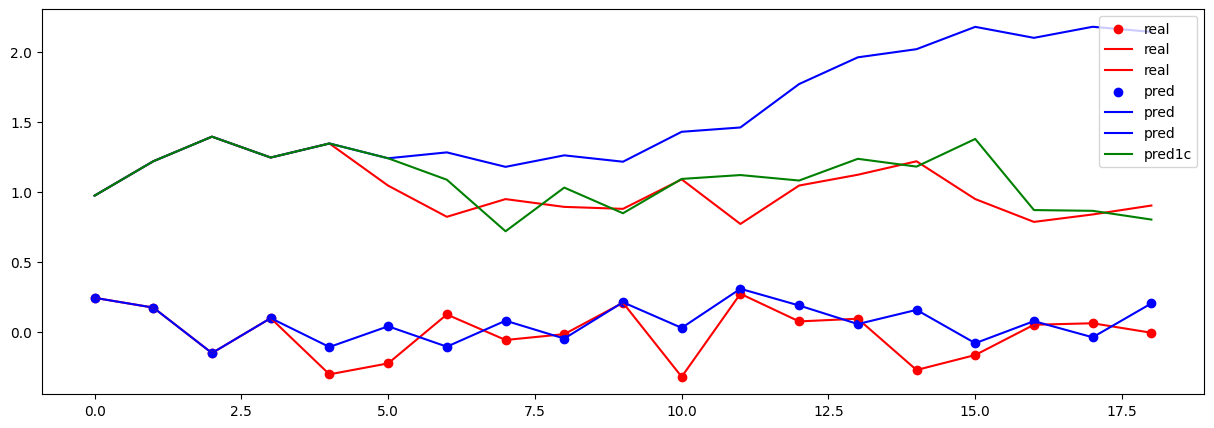

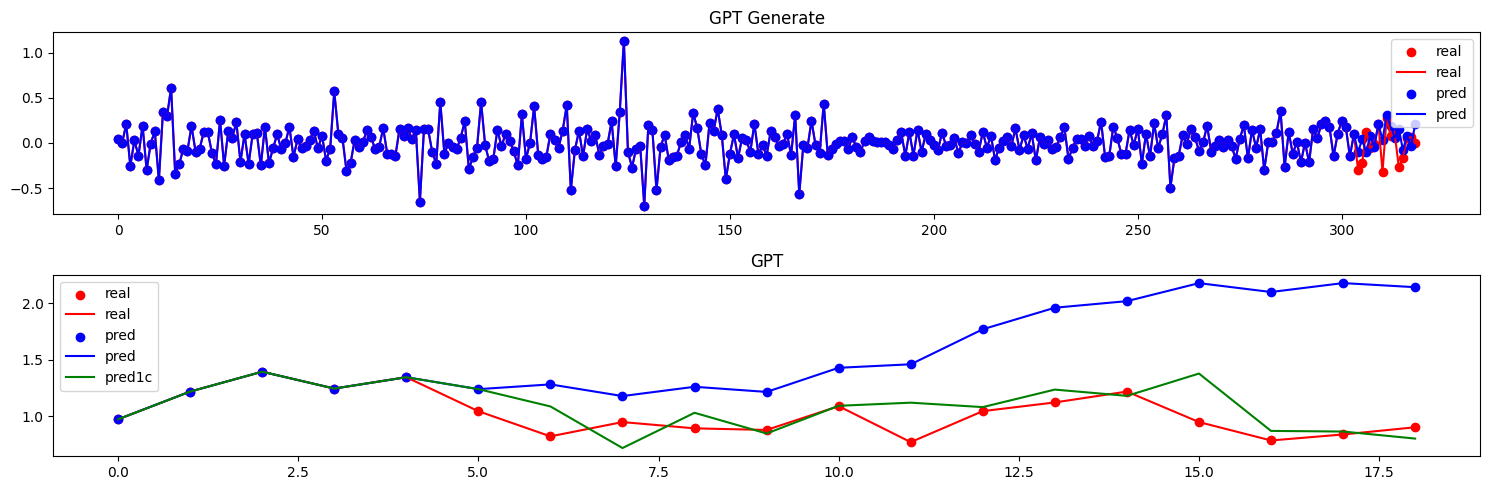

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.5083893537521362
500 train loss =  0.14182916283607483
1000 train loss =  0.06507034599781036
1500 train loss =  0.028340818360447884
2000 train loss =  0.017747607082128525
2500 train loss =  0.011432379484176636


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


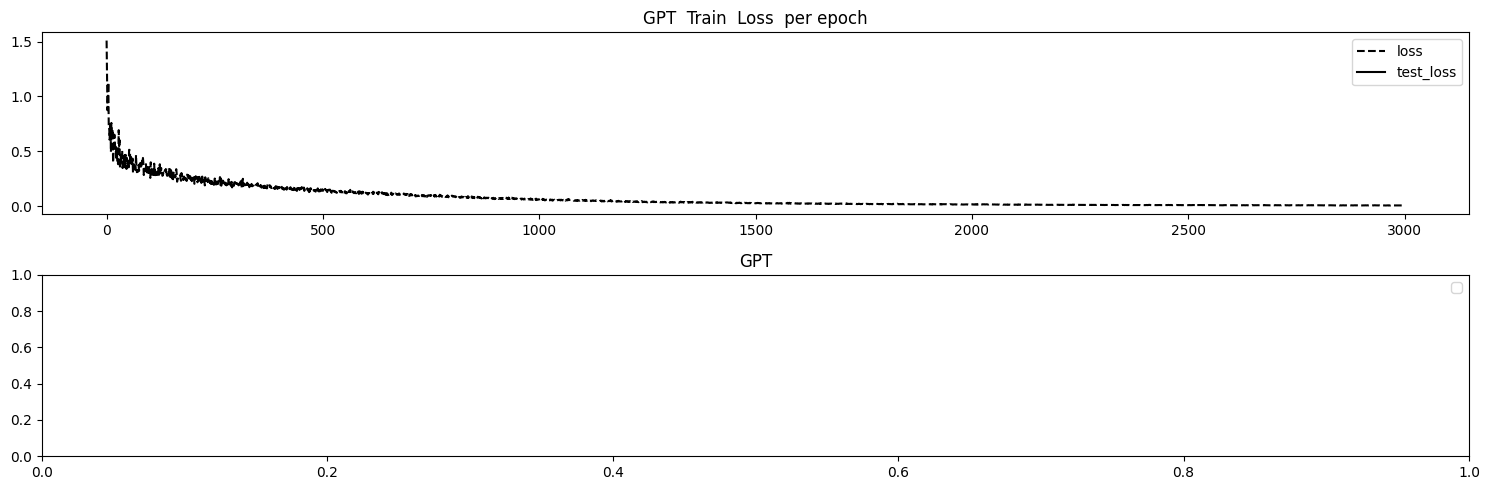

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0437607578933239
mae, mse, rmse, mape, mspe, rse, corr
(0.15903135, 0.043760758, 0.20919073, 1.3140874, 3.4288454, 1.155807)
Testing R**2 - SI only:  -0.33588998204271947
Testing R**2 - SI only:  -0.33588998204271947
Testing R**2 - All features:  0.9974361658642623


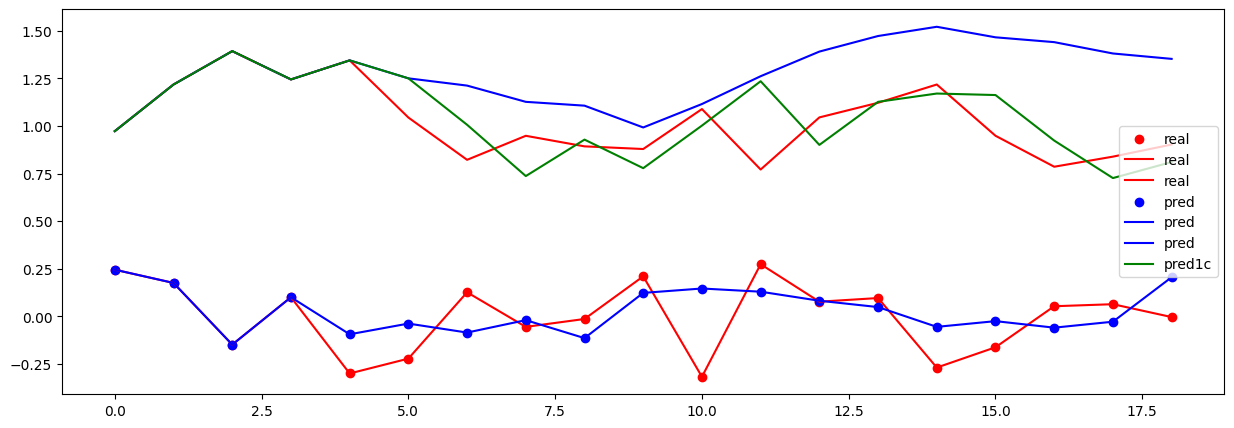

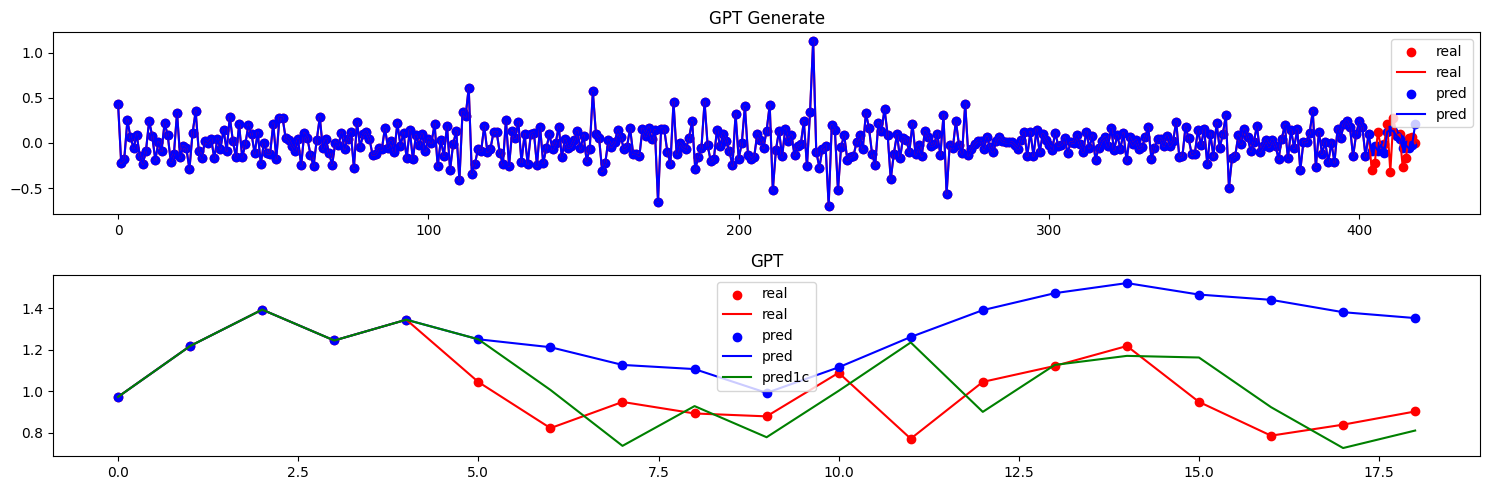

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [90]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
225
640
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.3025413751602173
500 train loss =  0.04303830489516258
1000 train loss =  0.01399464625865221
1500 train loss =  0.00734679913148284
2000 train loss =  0.004882156383246183
2500 train loss =  0.0036408600863069296


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


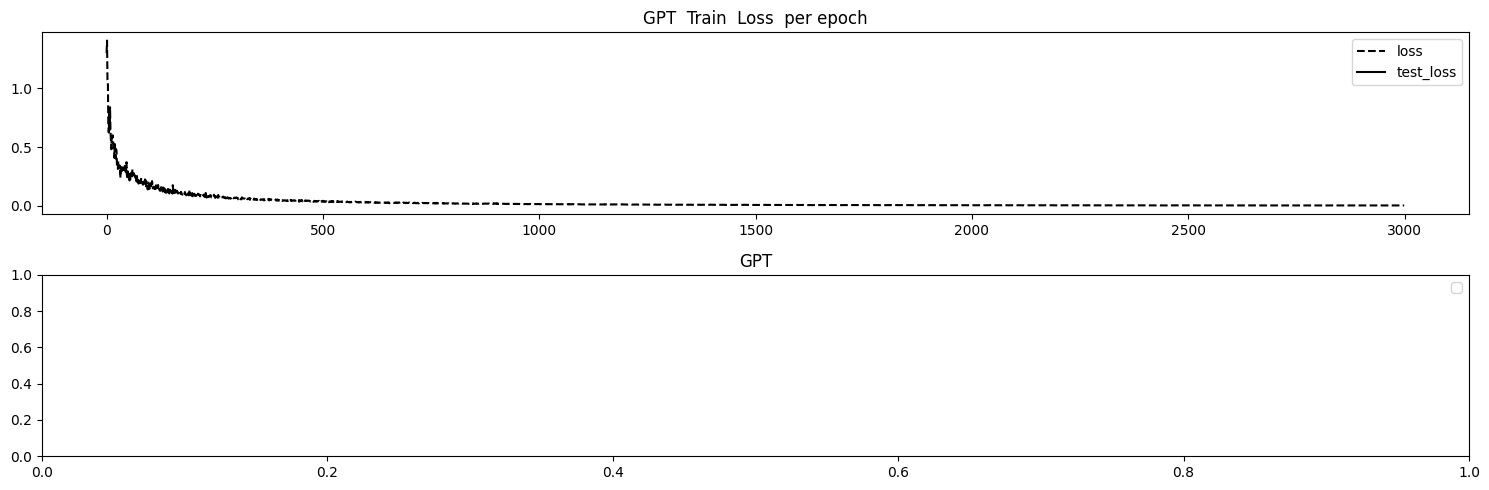

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07270338386297226
mae, mse, rmse, mape, mspe, rse, corr
(0.21053247, 0.072703384, 0.26963565, 3.3457608, 36.763683, 1.478119)
Testing R**2 - SI only:  -1.1848360082054072
Testing R**2 - SI only:  -1.1848360082054072
Testing R**2 - All features:  0.9635781138367814


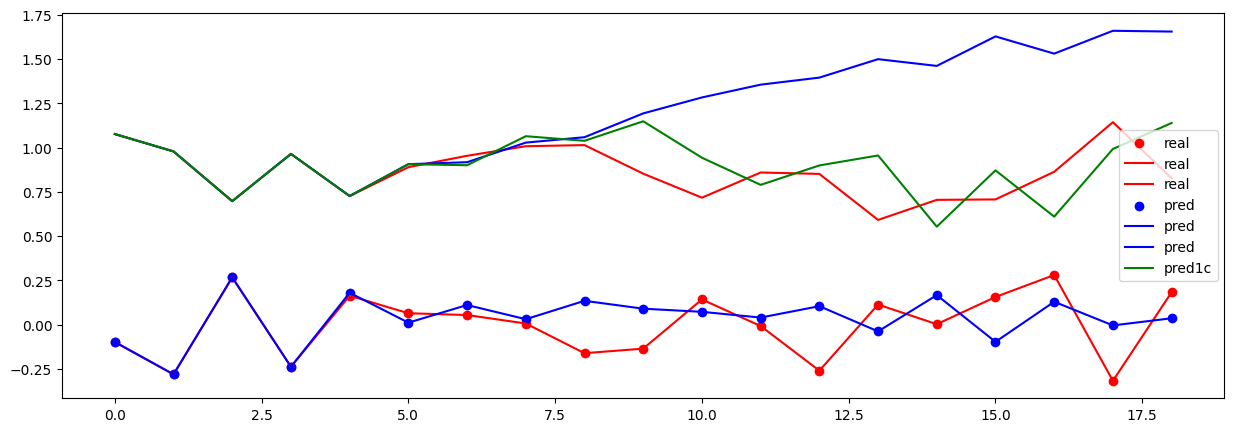

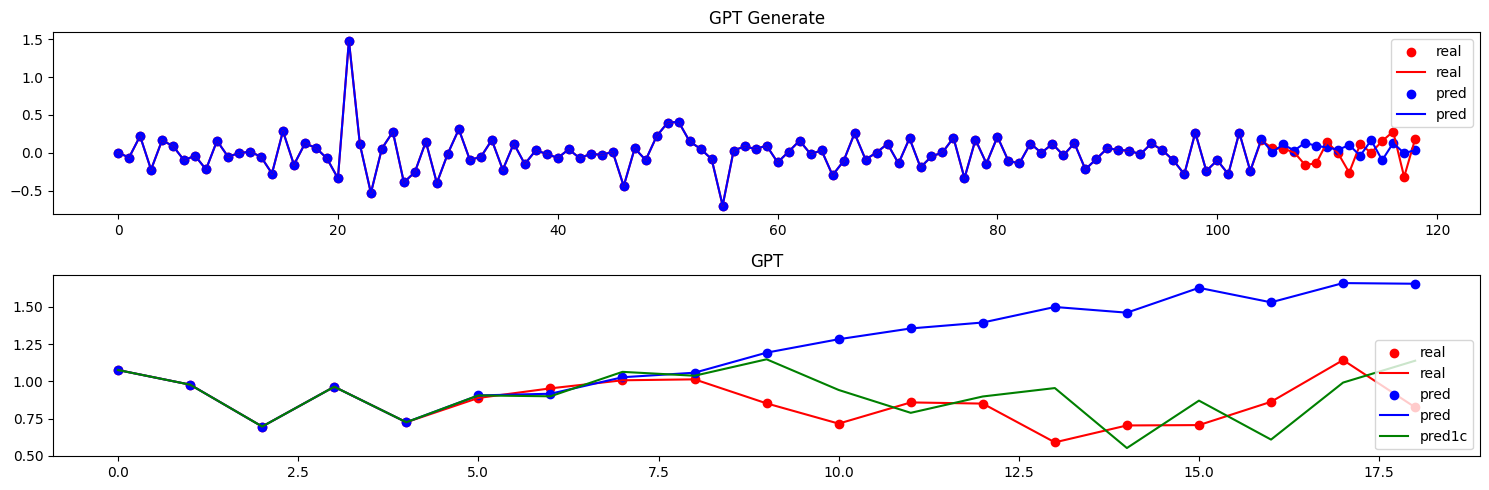

In [91]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.2595876455307007
500 train loss =  0.09239917993545532
1000 train loss =  0.031259115785360336
1500 train loss =  0.015908630564808846
2000 train loss =  0.010397057980298996
2500 train loss =  0.006423045415431261


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


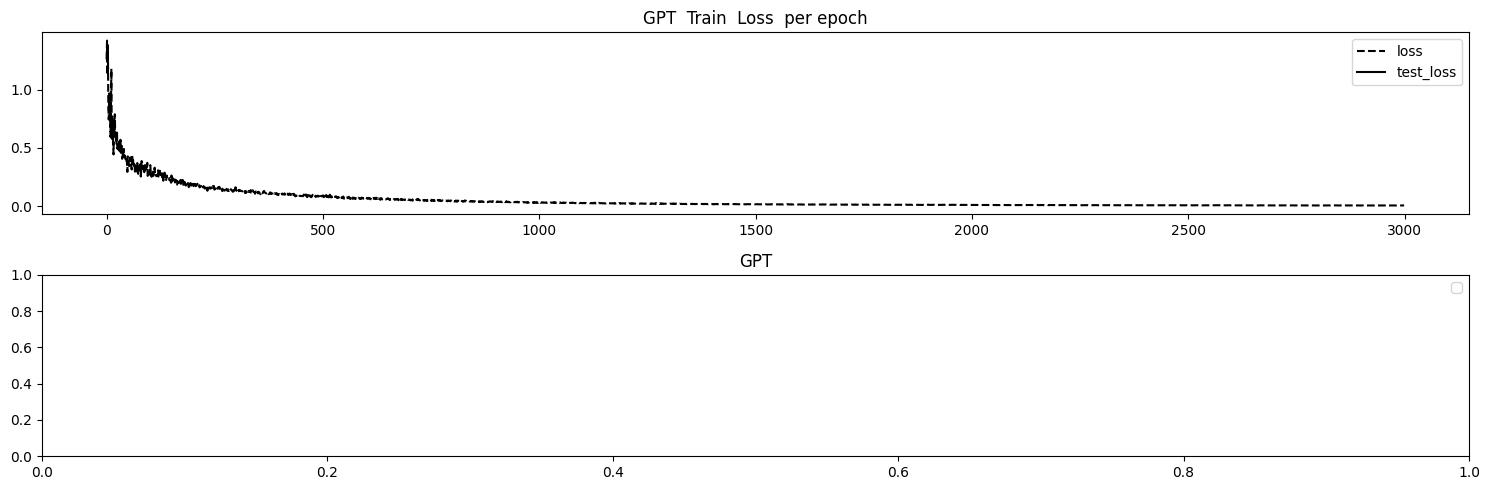

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.06296047568321228
mae, mse, rmse, mape, mspe, rse, corr
(0.20084497, 0.06296047, 0.25091925, 3.2493827, 44.5759, 1.3755174)
Testing R**2 - SI only:  -0.8920482964453134
Testing R**2 - SI only:  -0.8920482964453134
Testing R**2 - All features:  0.9681079163690867


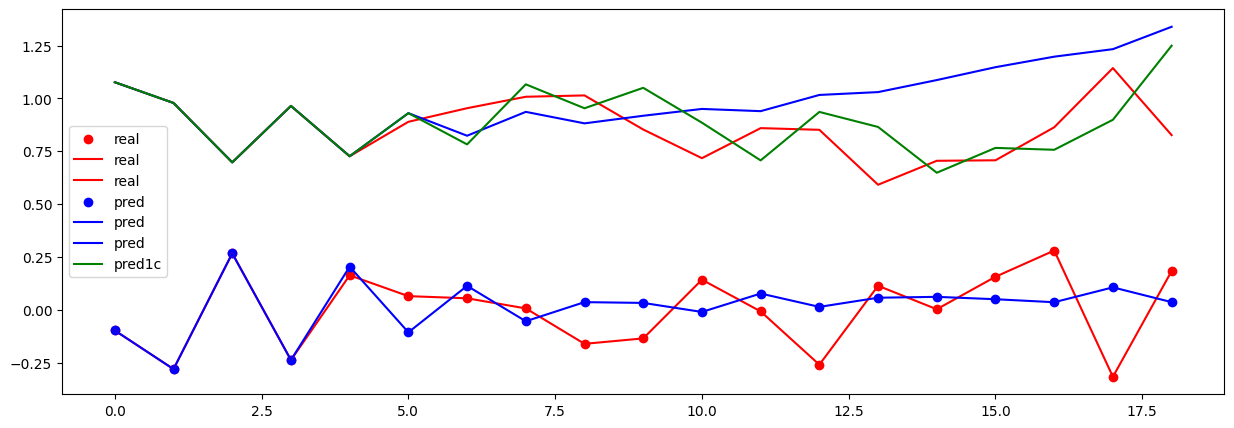

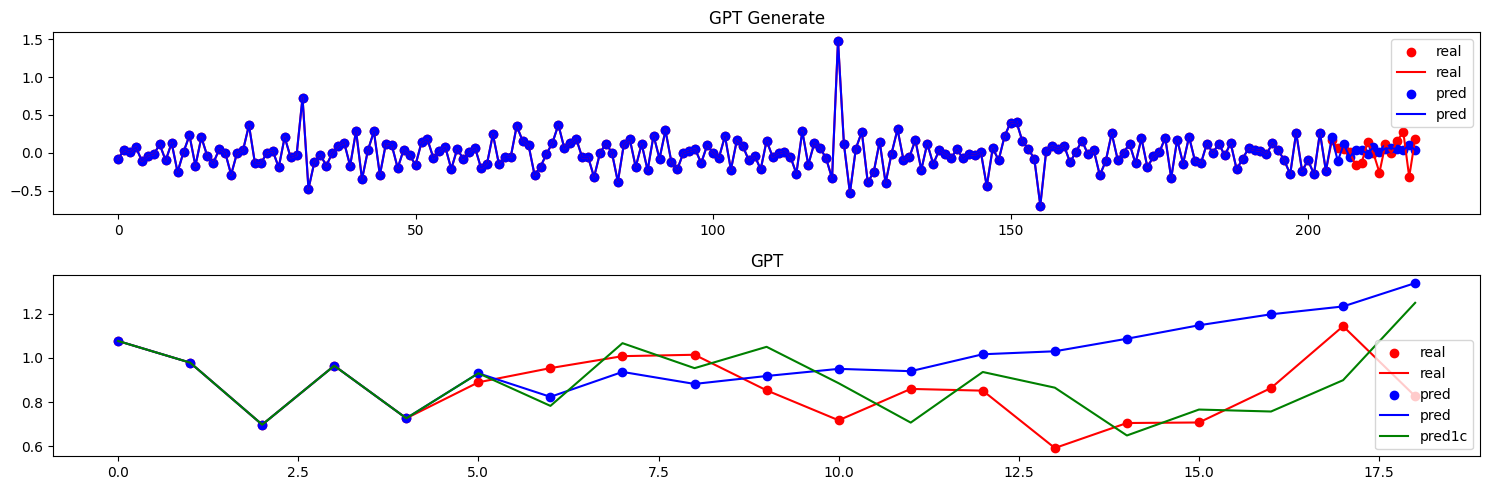

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



torch.Size([300, 25])
0 train loss =  1.3471944332122803
500 train loss =  0.09970483183860779
1000 train loss =  0.04784485325217247
1500 train loss =  0.024182647466659546
2000 train loss =  0.012782554142177105
2500 train loss =  0.009029175154864788


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


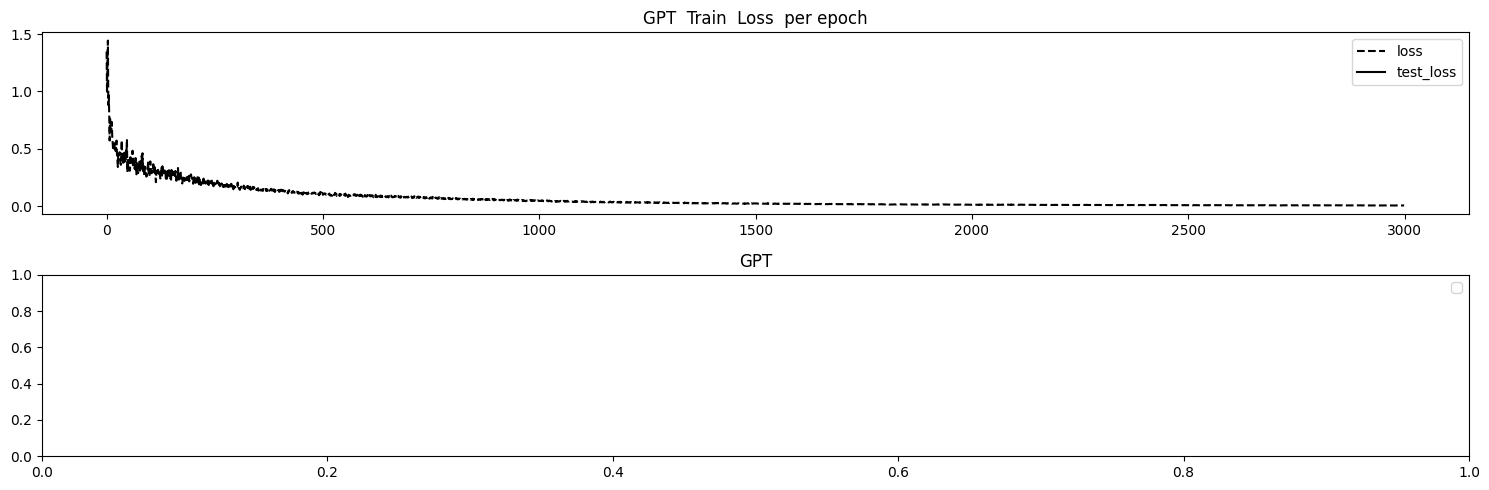

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.05608455836772919
mae, mse, rmse, mape, mspe, rse, corr
(0.17116511, 0.05608455, 0.23682177, 3.7611396, 117.82131, 1.2982361)
Testing R**2 - SI only:  -0.685417626774389
Testing R**2 - SI only:  -0.685417626774389
Testing R**2 - All features:  0.963967960973335


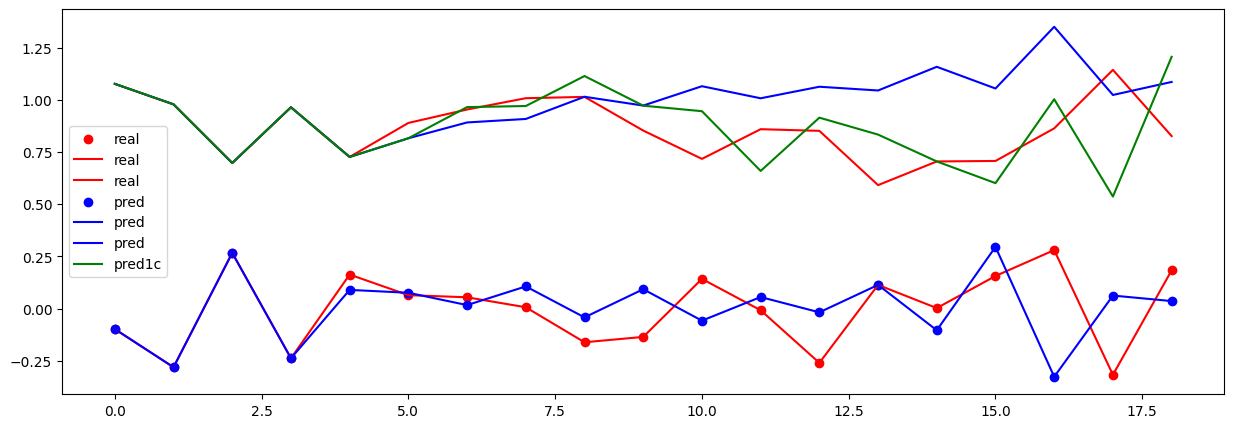

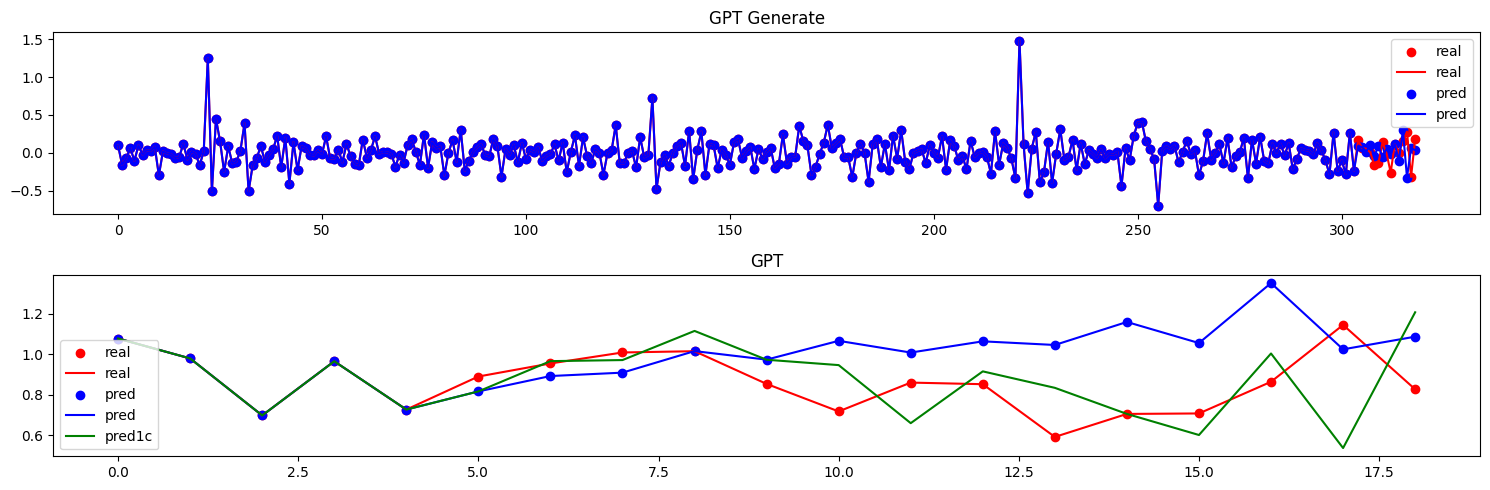

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.3007323741912842
500 train loss =  0.16632923483848572
1000 train loss =  0.06410952657461166
1500 train loss =  0.03174956887960434
2000 train loss =  0.018426215276122093
2500 train loss =  0.011851882562041283


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


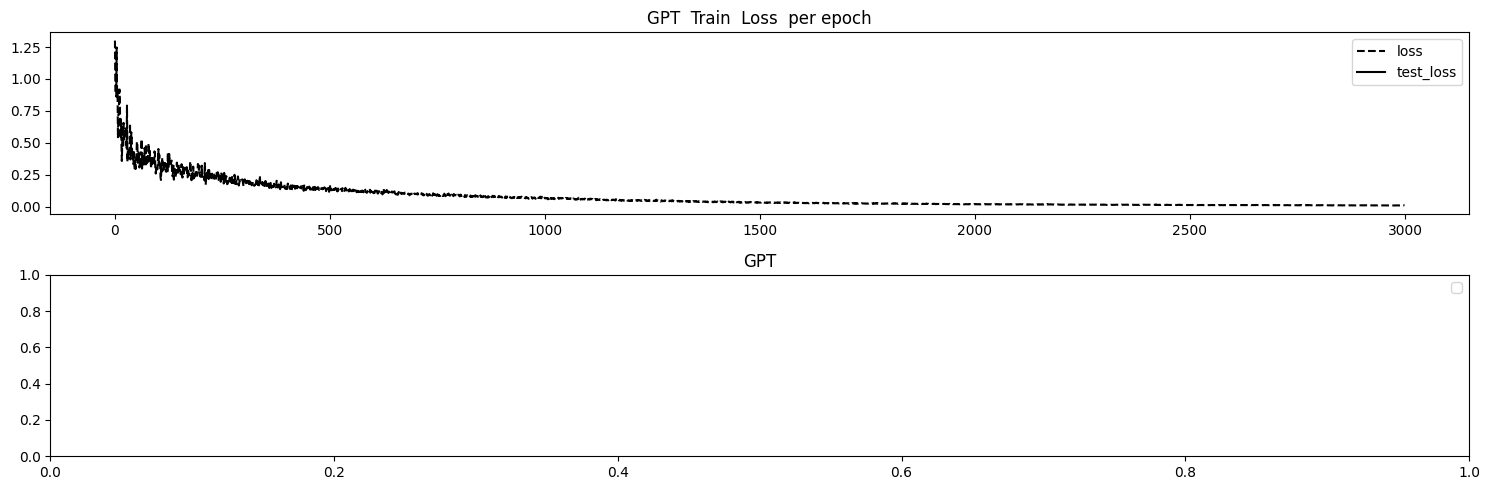

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07226953655481339
mae, mse, rmse, mape, mspe, rse, corr
(0.22106542, 0.07226953, 0.2688299, 2.4119432, 11.189411, 1.4737022)
Testing R**2 - SI only:  -1.1717980608668097
Testing R**2 - SI only:  -1.1717980608668097
Testing R**2 - All features:  0.9608964905719432


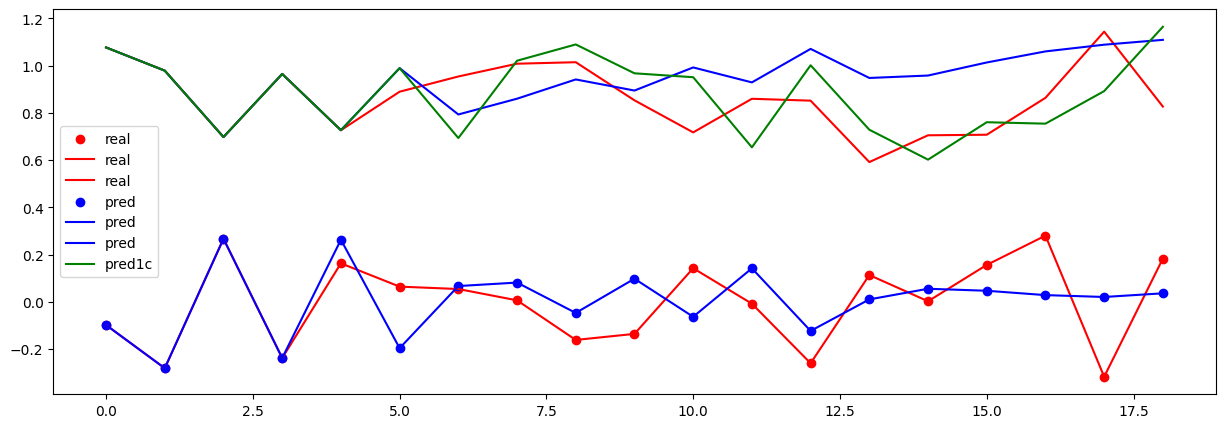

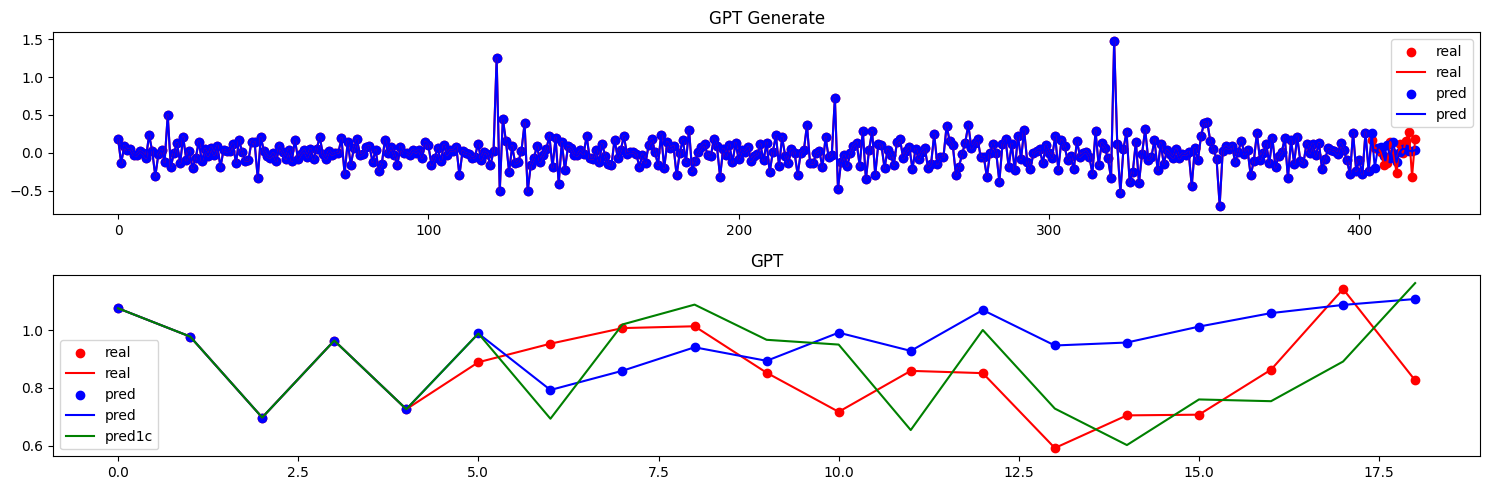

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [95]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
640
1055
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.2090922594070435
500 train loss =  0.036688633263111115
1000 train loss =  0.012813304550945759
1500 train loss =  0.007801297586411238
2000 train loss =  0.0053592706099152565
2500 train loss =  0.004077151417732239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


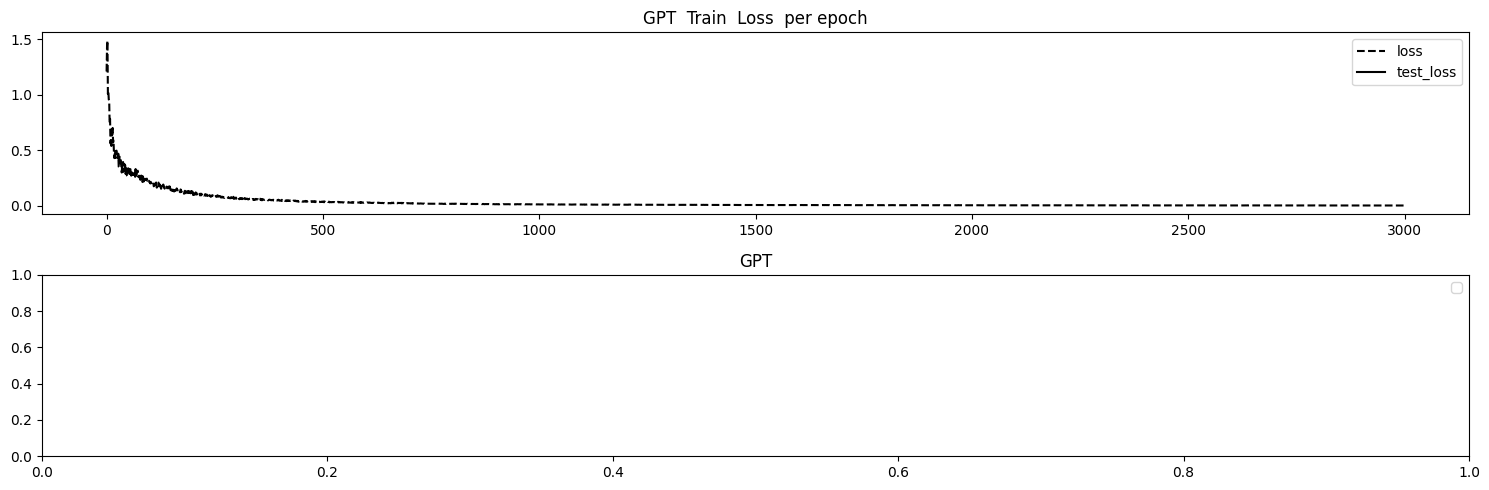

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.07543034106492996
mae, mse, rmse, mape, mspe, rse, corr
(0.17584164, 0.07543035, 0.27464586, 3.5080185, 38.570213, 1.50494)
Testing R**2 - SI only:  -1.2648443646248468
Testing R**2 - SI only:  -1.2648443646248468
Testing R**2 - All features:  0.9835060463788426


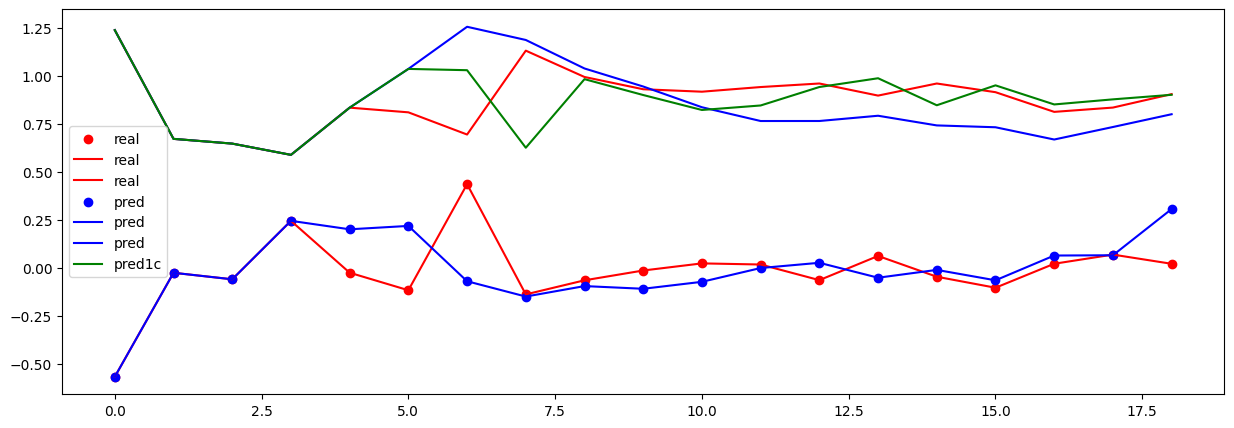

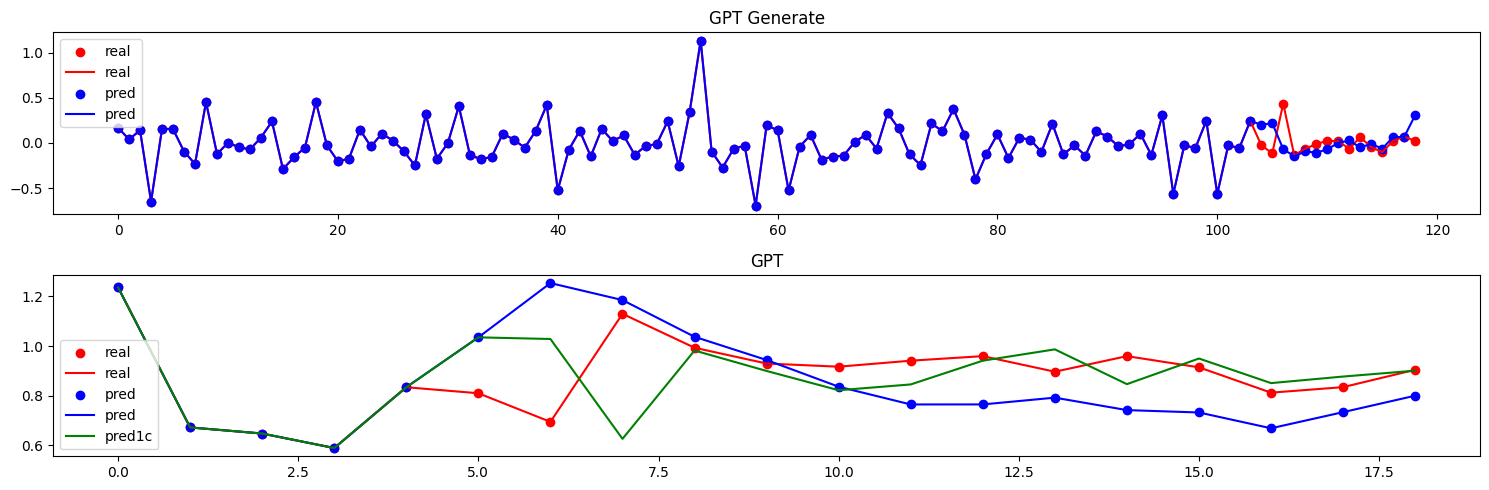

In [96]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.4968600273132324
500 train loss =  0.08012238144874573
1000 train loss =  0.026905689388513565
1500 train loss =  0.012962397187948227
2000 train loss =  0.008593791164457798
2500 train loss =  0.005643616896122694


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


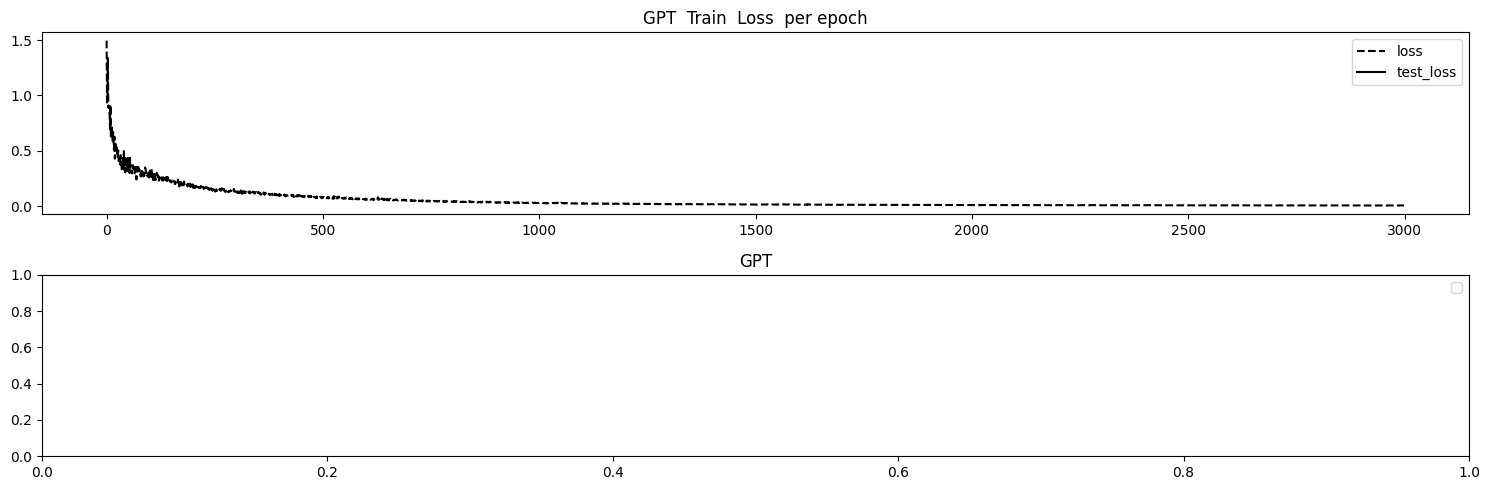

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0806439146399498
mae, mse, rmse, mape, mspe, rse, corr
(0.1997877, 0.08064391, 0.2839787, 4.8598433, 67.33987, 1.5560799)
Testing R**2 - SI only:  -1.4213848899156103
Testing R**2 - SI only:  -1.4213848899156103
Testing R**2 - All features:  0.9869436545062855


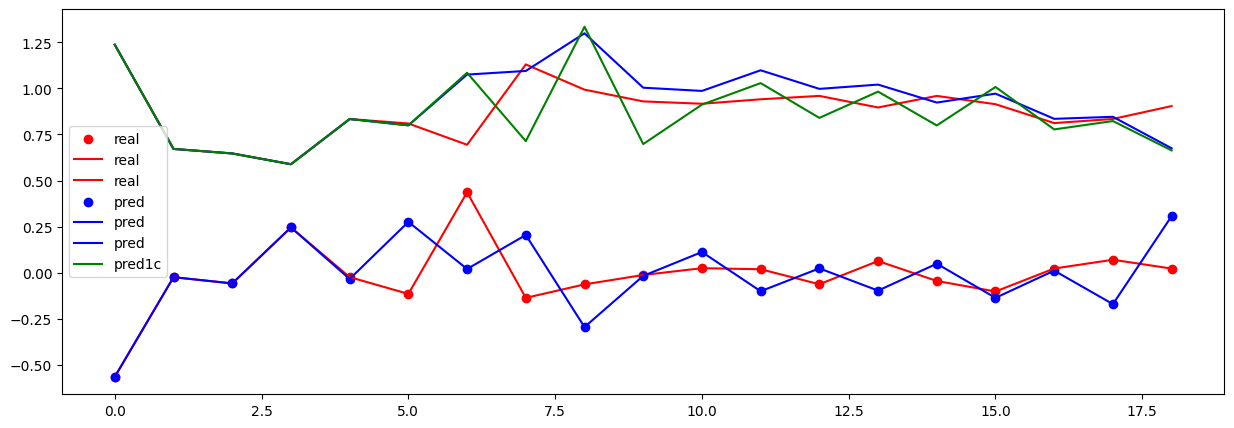

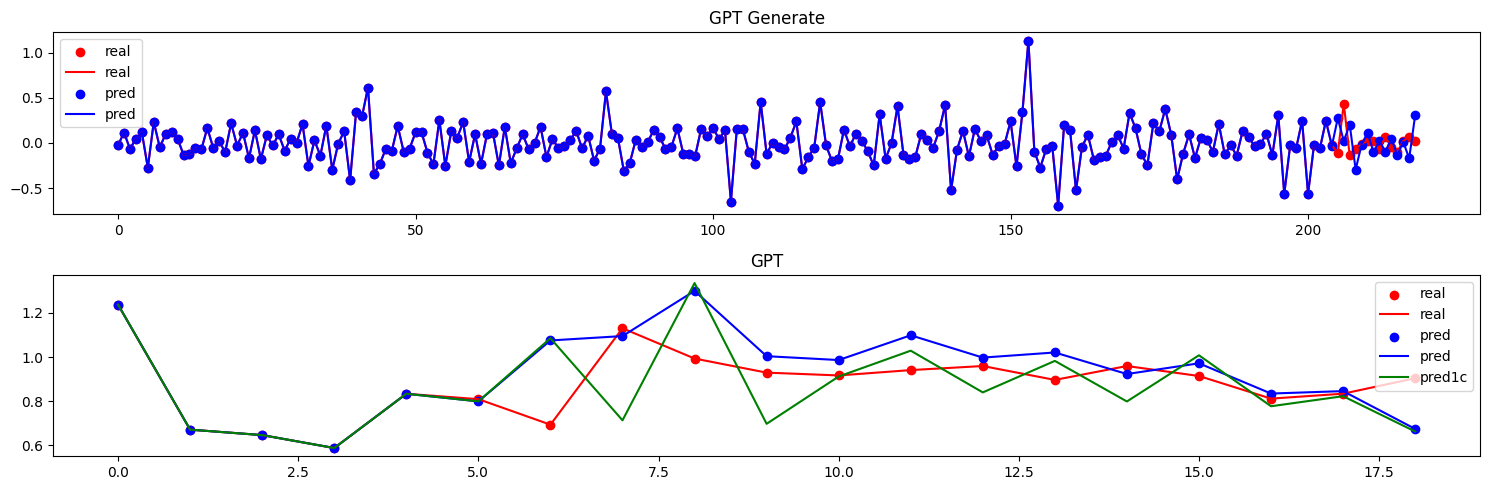

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.0048621892929077
500 train loss =  0.10895155370235443
1000 train loss =  0.039619967341423035
1500 train loss =  0.019433803856372833
2000 train loss =  0.012354702688753605
2500 train loss =  0.008764000609517097


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


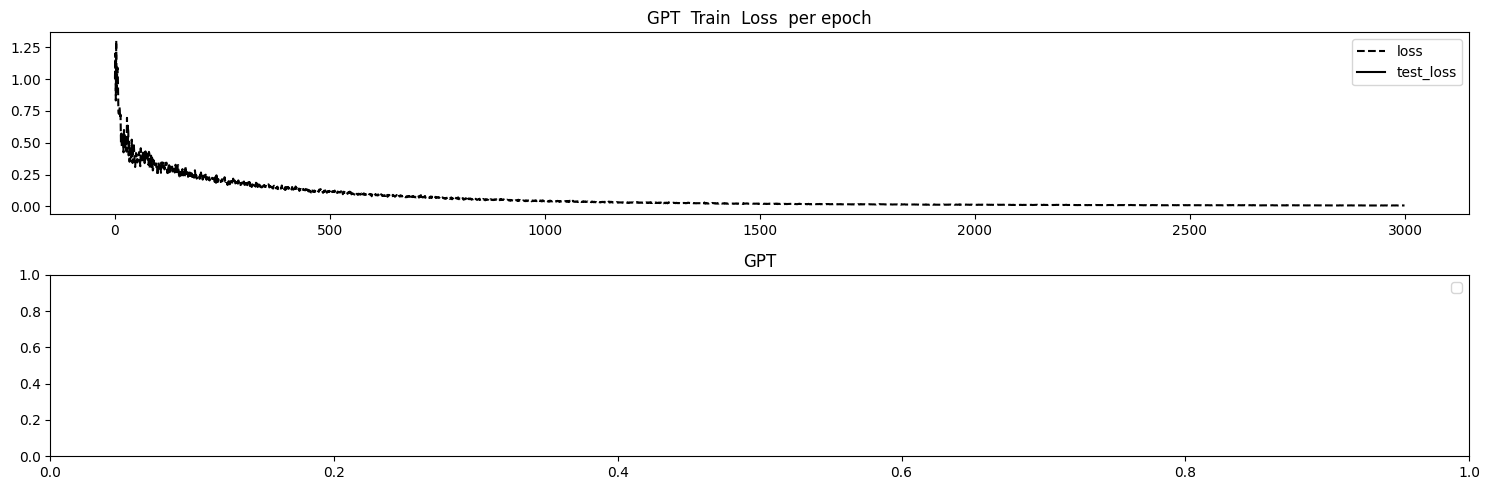

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.08367621898651123
mae, mse, rmse, mape, mspe, rse, corr
(0.18839315, 0.08367623, 0.28926843, 3.320793, 36.80645, 1.5850654)
Testing R**2 - SI only:  -1.5124319024168429
Testing R**2 - SI only:  -1.5124319024168429
Testing R**2 - All features:  0.9824377368712902


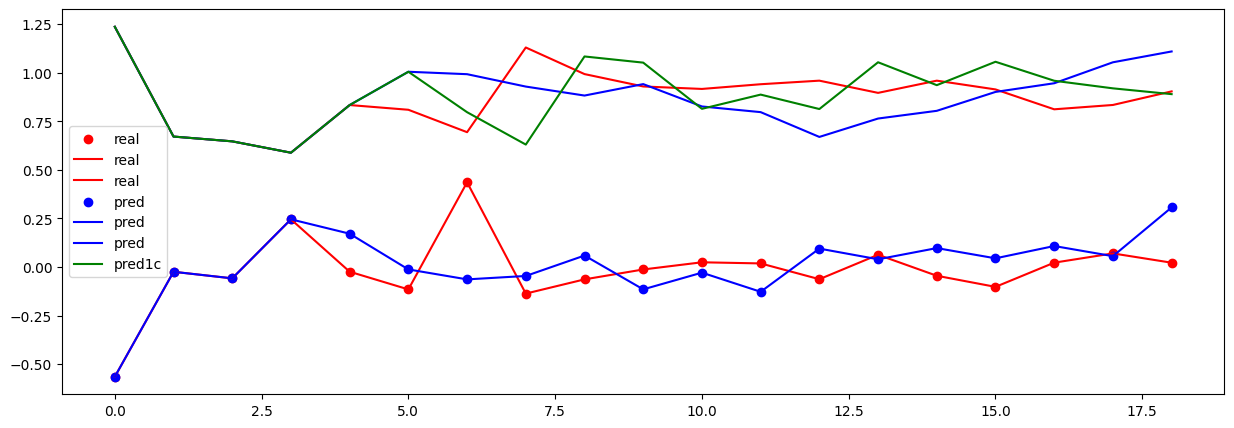

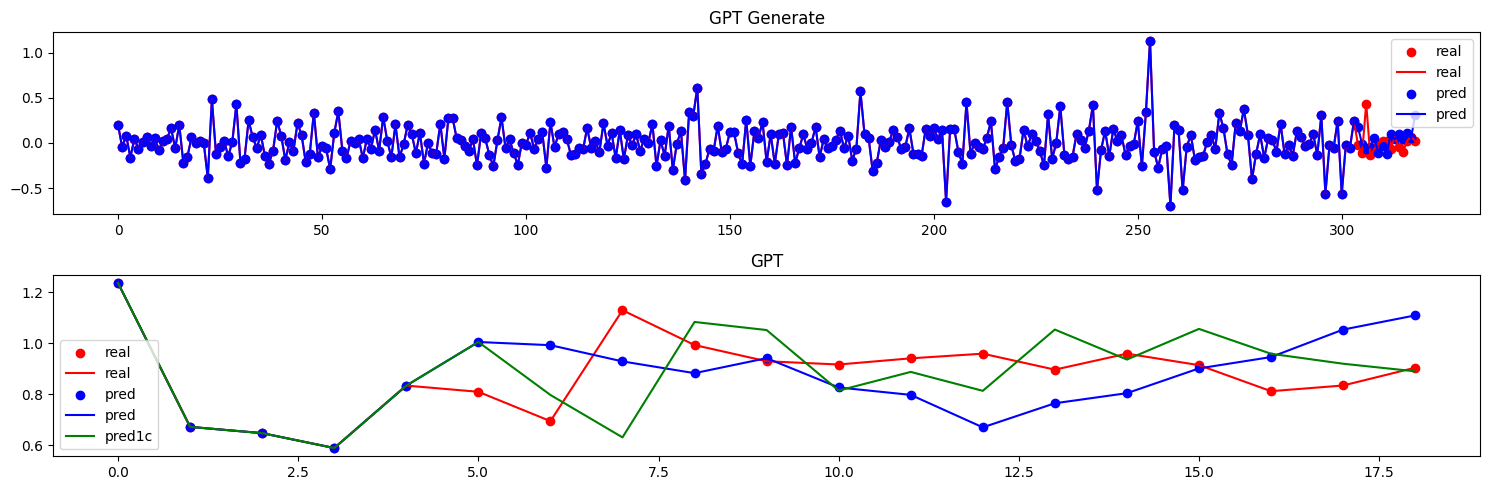

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([400, 25])
0 train loss =  1.171236515045166
500 train loss =  0.17644216120243073
1000 train loss =  0.058583710342645645
1500 train loss =  0.028966577723622322
2000 train loss =  0.01561168022453785
2500 train loss =  0.011791946366429329


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


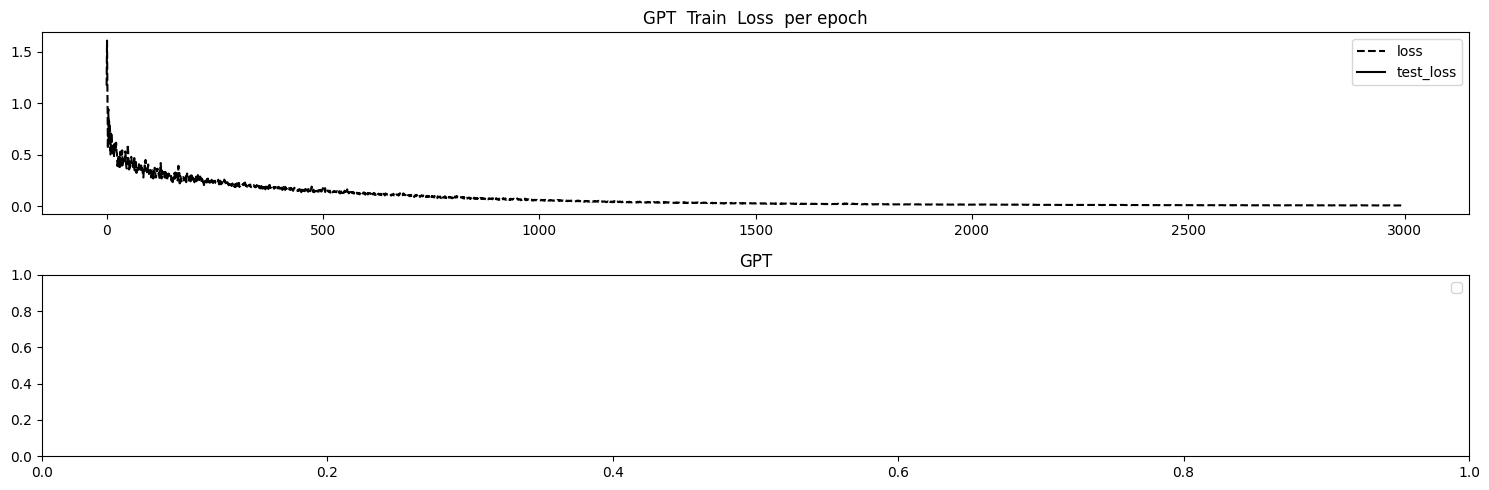

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.08642163127660751
mae, mse, rmse, mape, mspe, rse, corr
(0.19711088, 0.086421646, 0.2939756, 3.6196823, 41.119343, 1.6108584)
Testing R**2 - SI only:  -1.594865029056045
Testing R**2 - SI only:  -1.594865029056045
Testing R**2 - All features:  0.9812602755427335


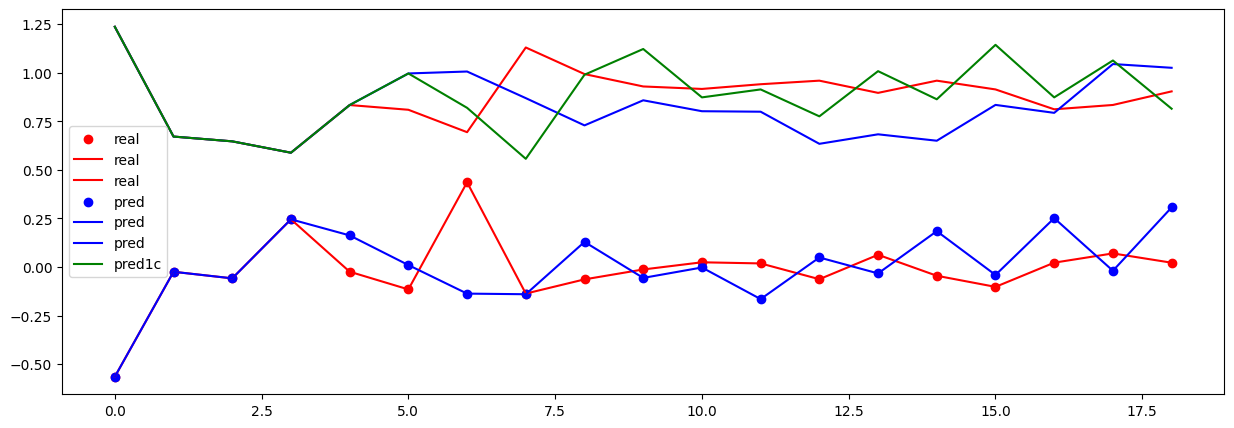

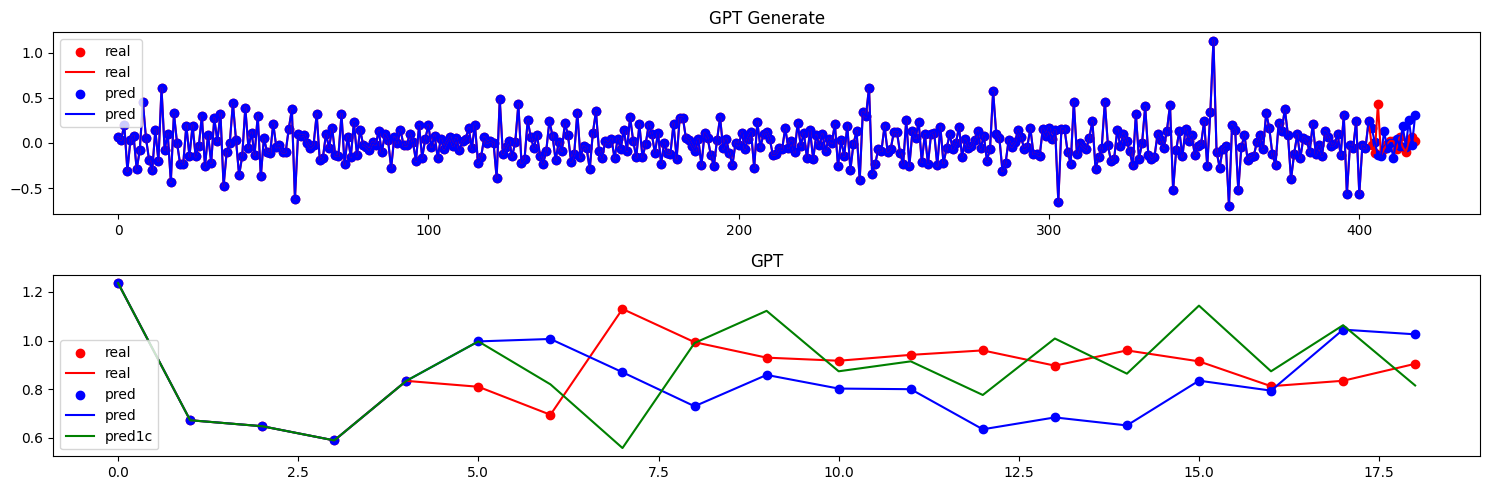

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [100]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
351
766
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.3265541791915894
500 train loss =  0.030090151354670525
1000 train loss =  0.012662981636822224
1500 train loss =  0.006728760898113251
2000 train loss =  0.005325755570083857
2500 train loss =  0.003920381888747215


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


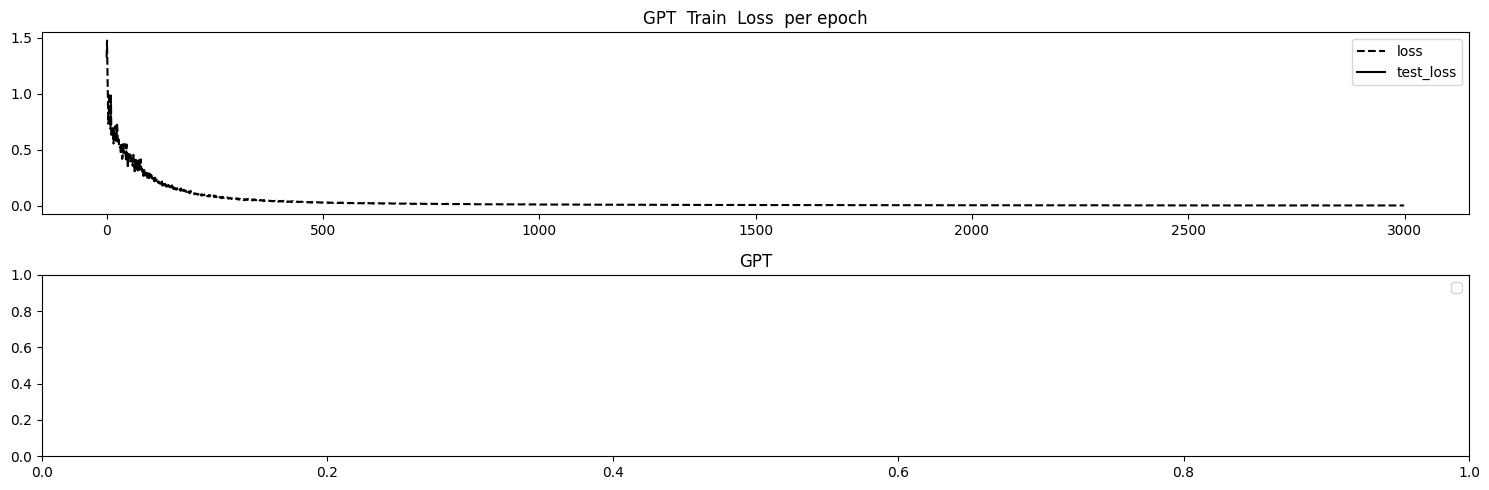

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03411130979657173
mae, mse, rmse, mape, mspe, rse, corr
(0.13559493, 0.03411131, 0.18469247, 92.28711, 154260.11, 1.0702629)
Testing R**2 - SI only:  -0.14546255791313234
Testing R**2 - SI only:  -0.14546255791313234
Testing R**2 - All features:  0.990816299275094


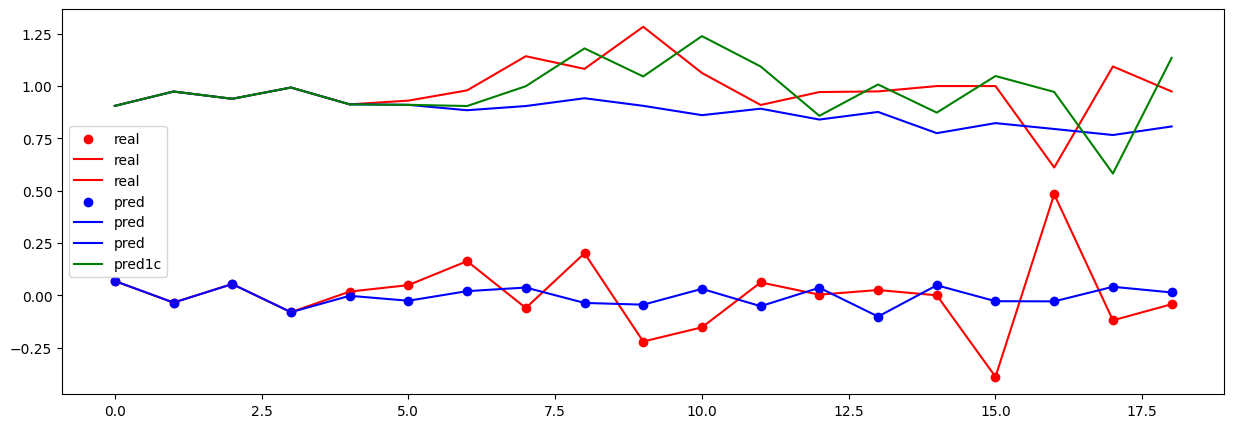

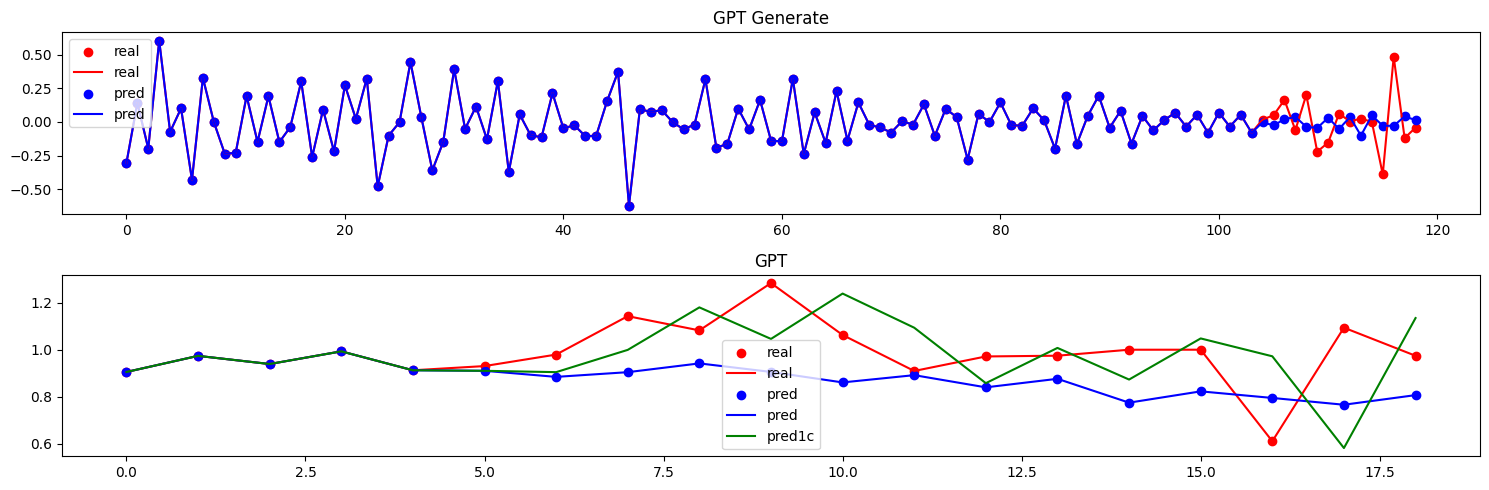

In [101]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.7269859313964844
500 train loss =  0.07611070573329926
1000 train loss =  0.024737859144806862
1500 train loss =  0.013134877197444439
2000 train loss =  0.008690189570188522
2500 train loss =  0.005941199604421854


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


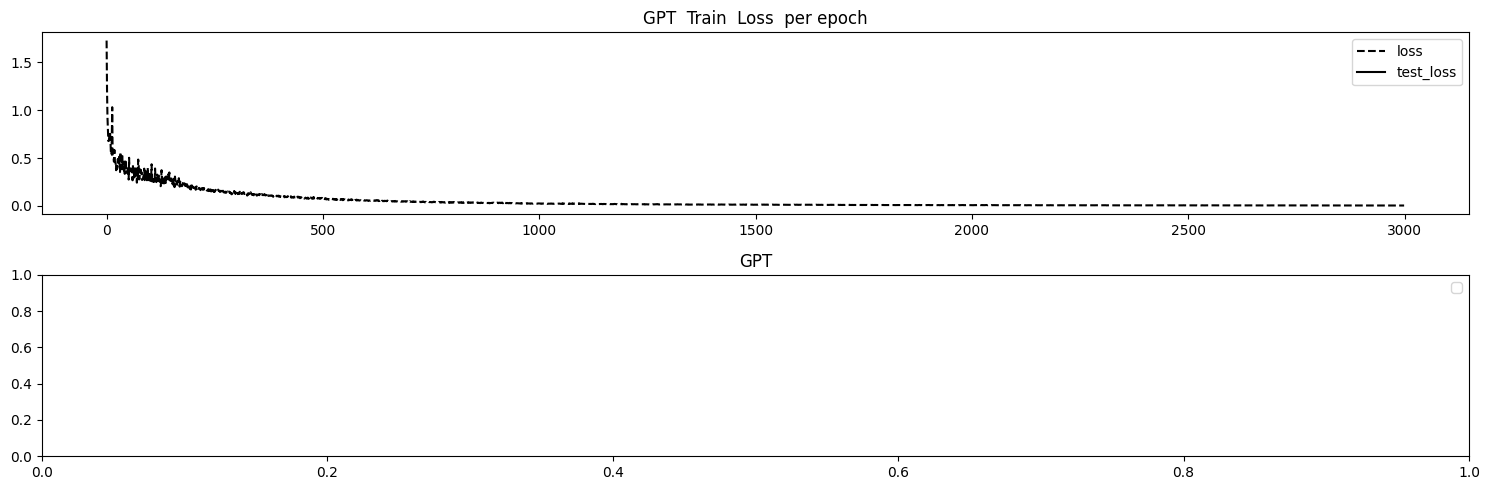

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03208576515316963
mae, mse, rmse, mape, mspe, rse, corr
(0.1380719, 0.032085765, 0.179125, 29.002962, 13934.274, 1.0380002)
Testing R**2 - SI only:  -0.07744446589088949
Testing R**2 - SI only:  -0.07744446589088949
Testing R**2 - All features:  0.9964583645873777


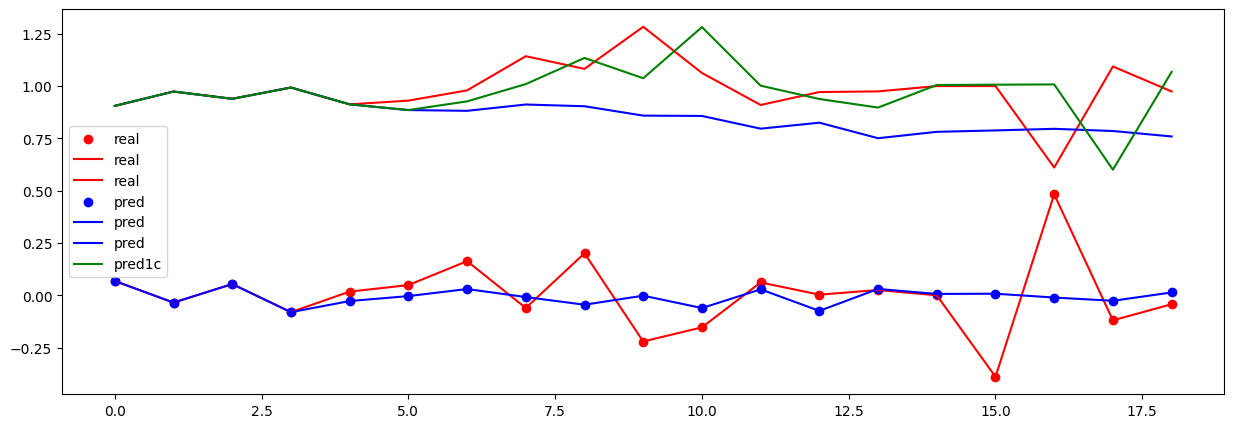

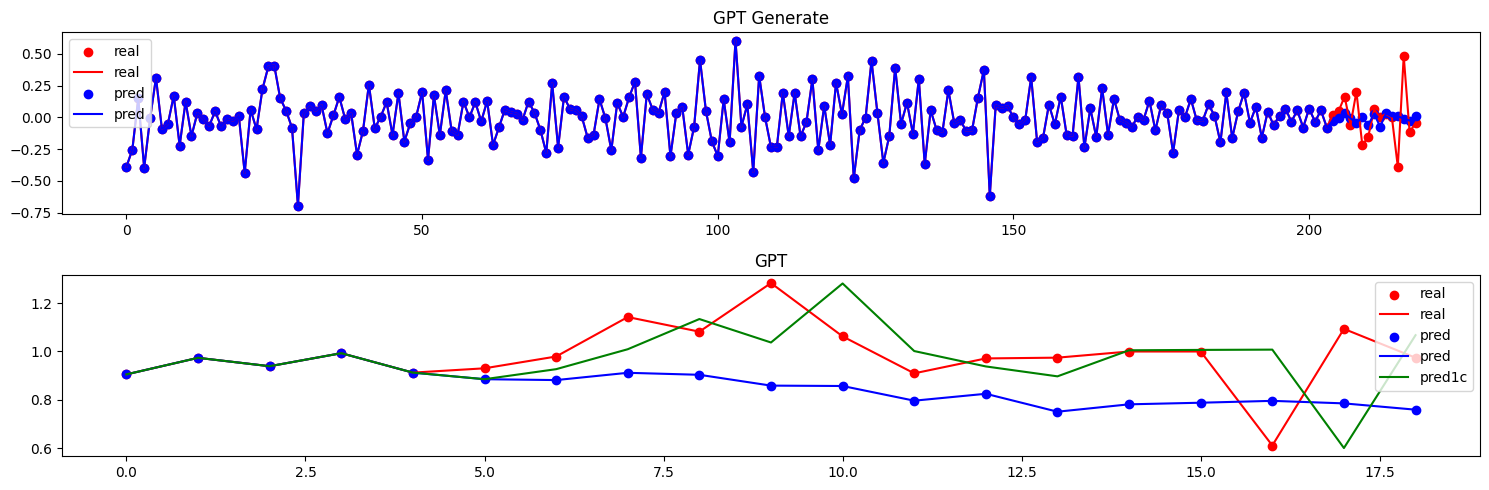

In [102]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.1884809732437134
500 train loss =  0.12188521027565002
1000 train loss =  0.04838483780622482
1500 train loss =  0.021925389766693115
2000 train loss =  0.01381655503064394
2500 train loss =  0.009504066780209541


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


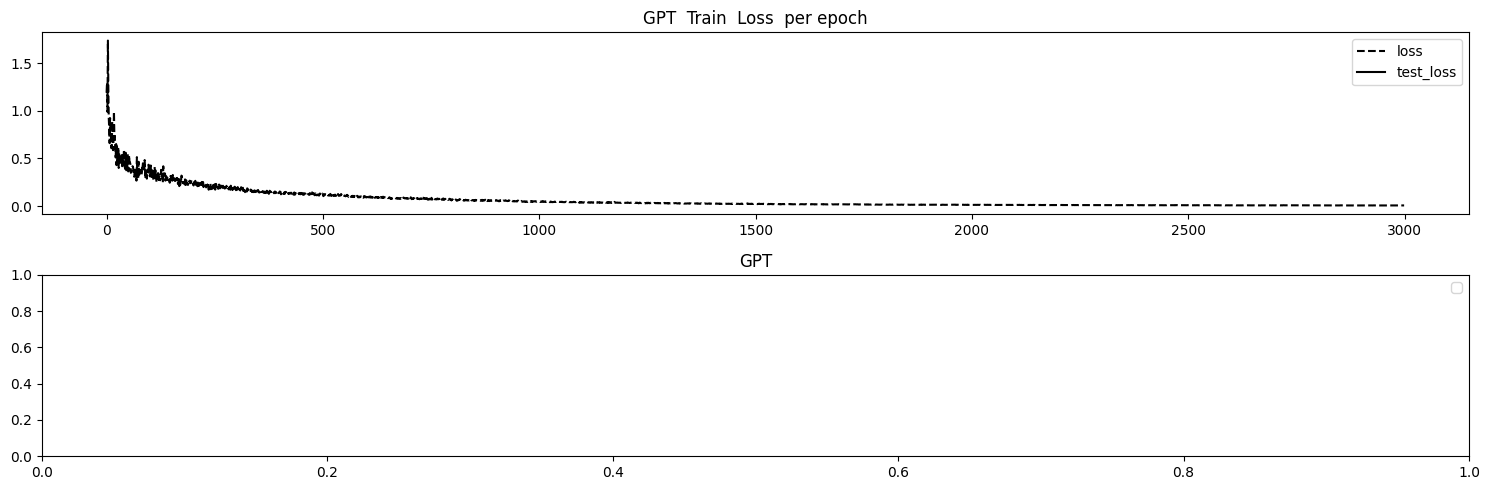

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.028466995805501938
mae, mse, rmse, mape, mspe, rse, corr
(0.12537773, 0.028466996, 0.16872165, 18.374022, 5427.3394, 0.9777145)
Testing R**2 - SI only:  0.04407431207238299
Testing R**2 - SI only:  0.04407431207238299
Testing R**2 - All features:  0.9958243323128699


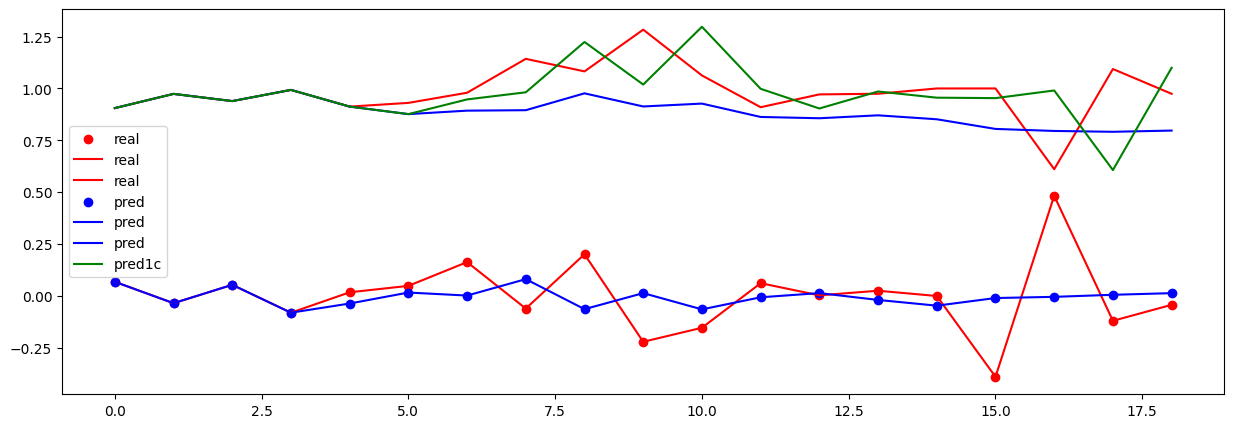

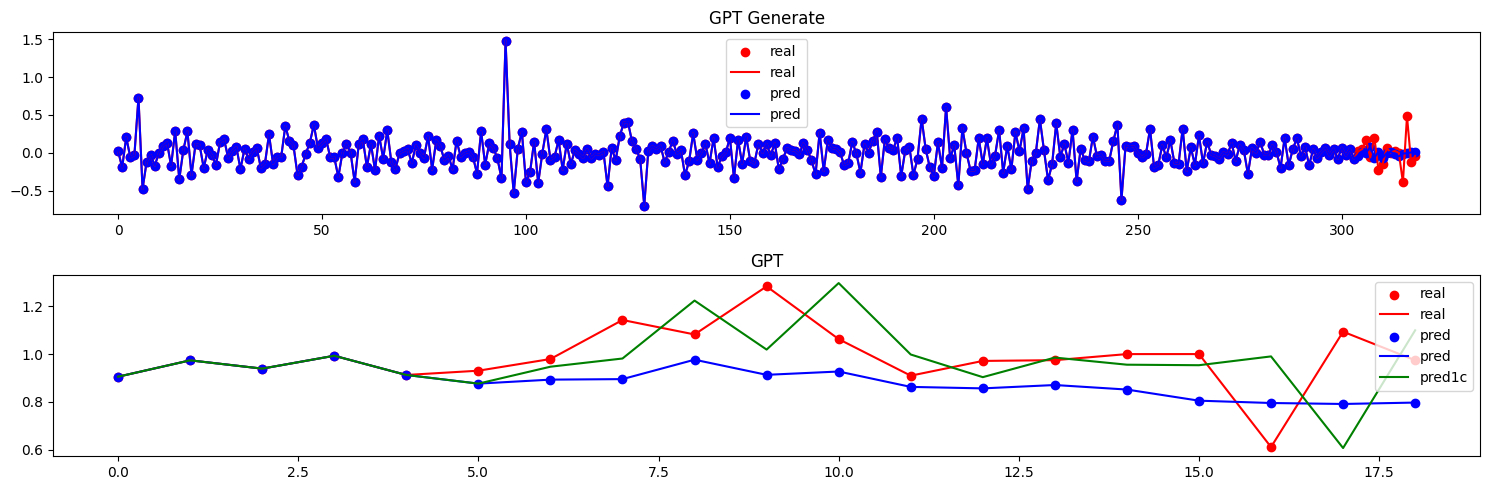

In [103]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.1605560779571533
500 train loss =  0.14461997151374817
1000 train loss =  0.06363753974437714
1500 train loss =  0.029282711446285248
2000 train loss =  0.017898008227348328
2500 train loss =  0.012217399664223194


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


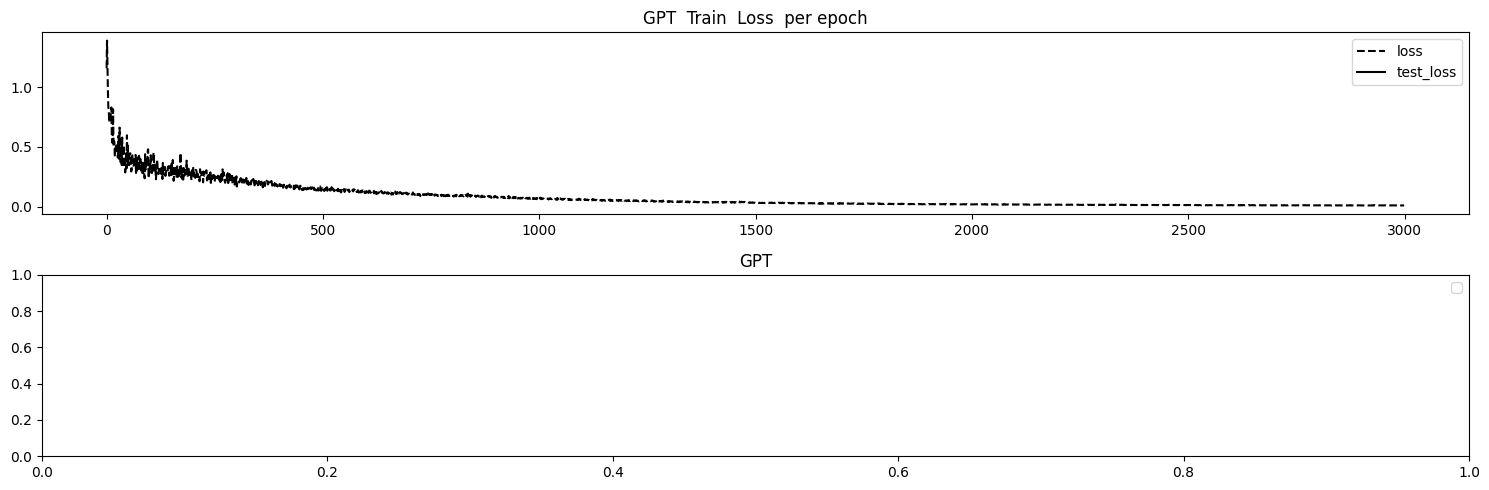

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.0333850122988224
mae, mse, rmse, mape, mspe, rse, corr
(0.142269, 0.033385012, 0.18271565, 25.949158, 10566.249, 1.0588075)
Testing R**2 - SI only:  -0.12107329477962758
Testing R**2 - SI only:  -0.12107329477962758
Testing R**2 - All features:  0.9965284000559266


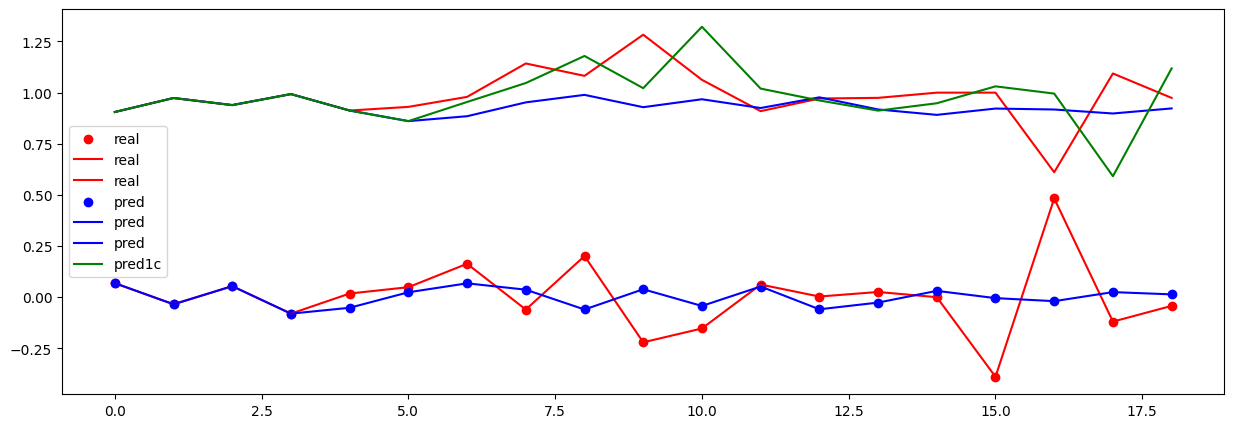

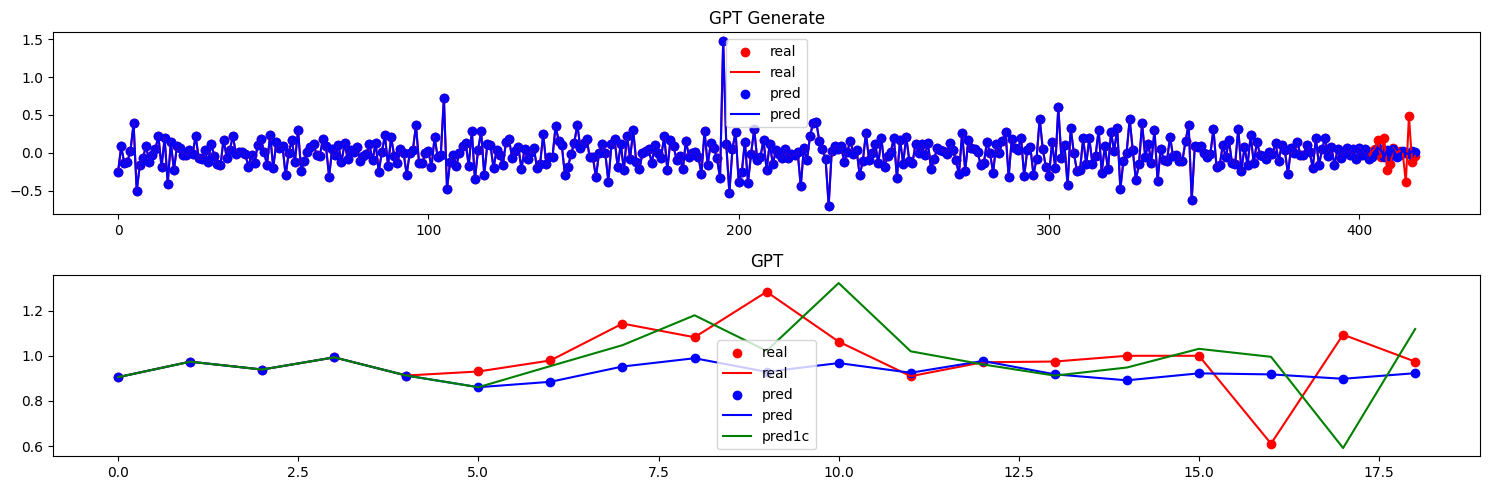

In [104]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [105]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
674
1089
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  1.335173487663269
500 train loss =  0.032140254974365234
1000 train loss =  0.013275711797177792
1500 train loss =  0.007372337393462658
2000 train loss =  0.004650171380490065
2500 train loss =  0.003789597423747182


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


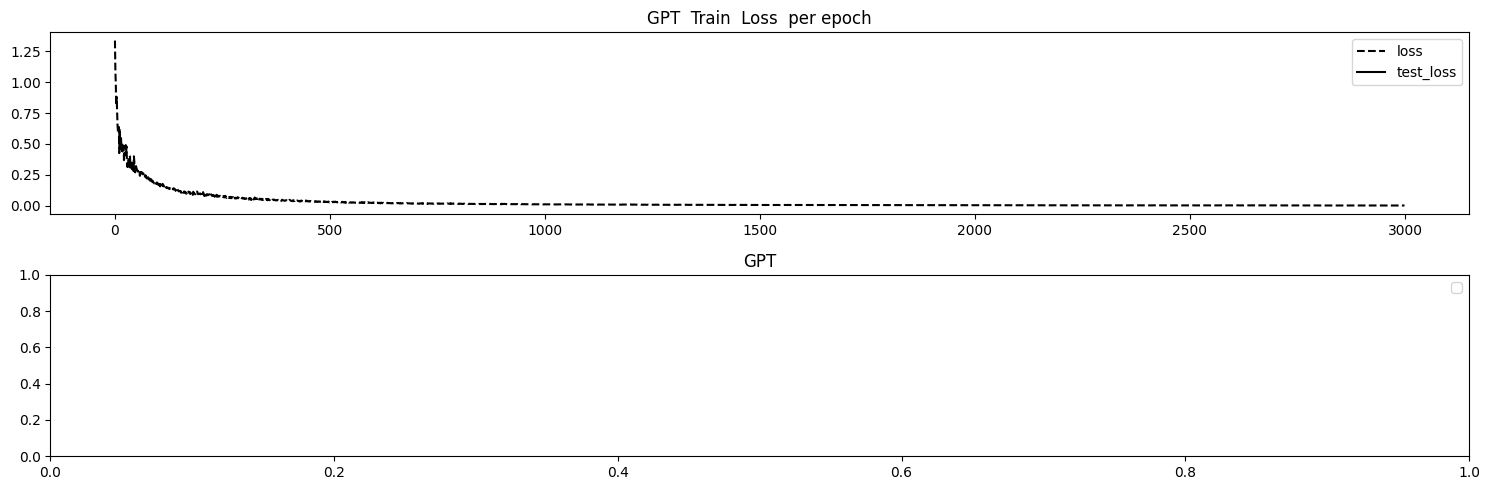

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.013171863742172718
mae, mse, rmse, mape, mspe, rse, corr
(0.09248848, 0.013171864, 0.11476874, 2.7649715, 22.42666, 1.4392488)
Testing R**2 - SI only:  -1.0714366187013282
Testing R**2 - SI only:  -1.0714366187013282
Testing R**2 - All features:  0.9993017674058576


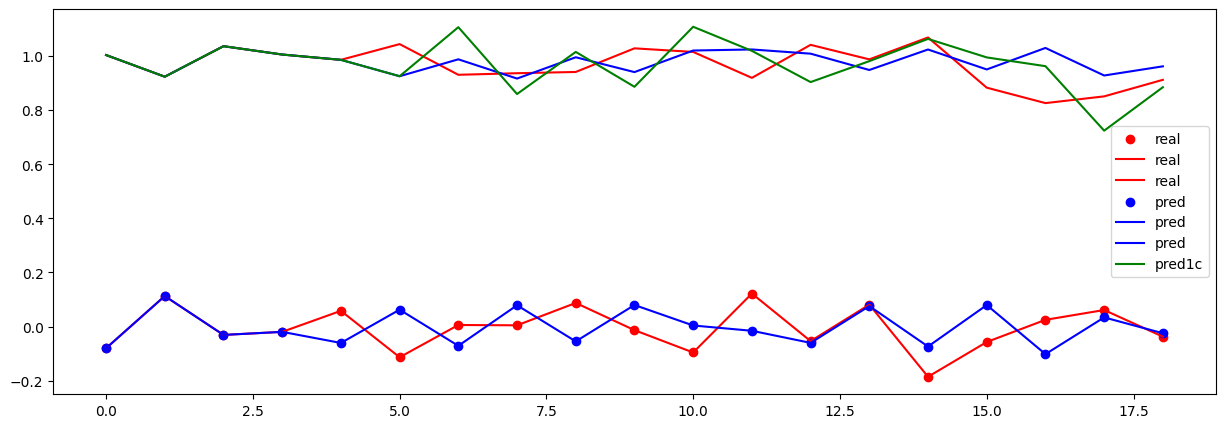

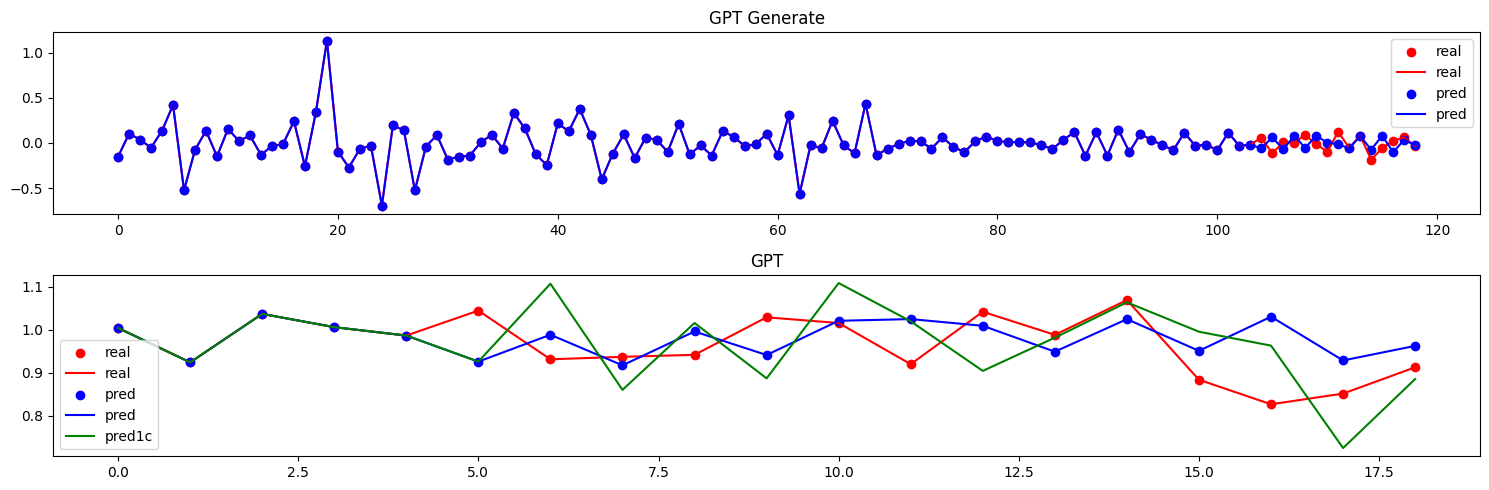

In [106]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([200, 25])
0 train loss =  1.413794755935669
500 train loss =  0.07268927246332169
1000 train loss =  0.025955770164728165
1500 train loss =  0.014383789151906967
2000 train loss =  0.008558620698750019
2500 train loss =  0.006584684830158949


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


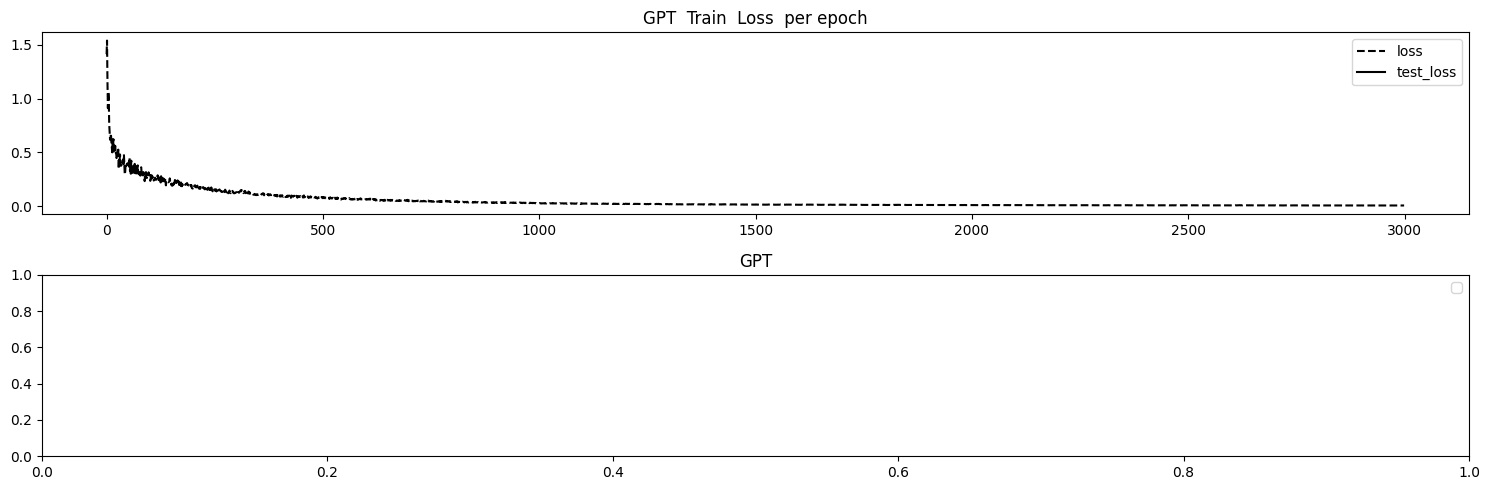

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.008382066152989864
mae, mse, rmse, mape, mspe, rse, corr
(0.07714907, 0.008382066, 0.09155362, 1.7284214, 6.128384, 1.1481214)
Testing R**2 - SI only:  -0.3181823982793863
Testing R**2 - SI only:  -0.3181823982793863
Testing R**2 - All features:  0.9987855078340211


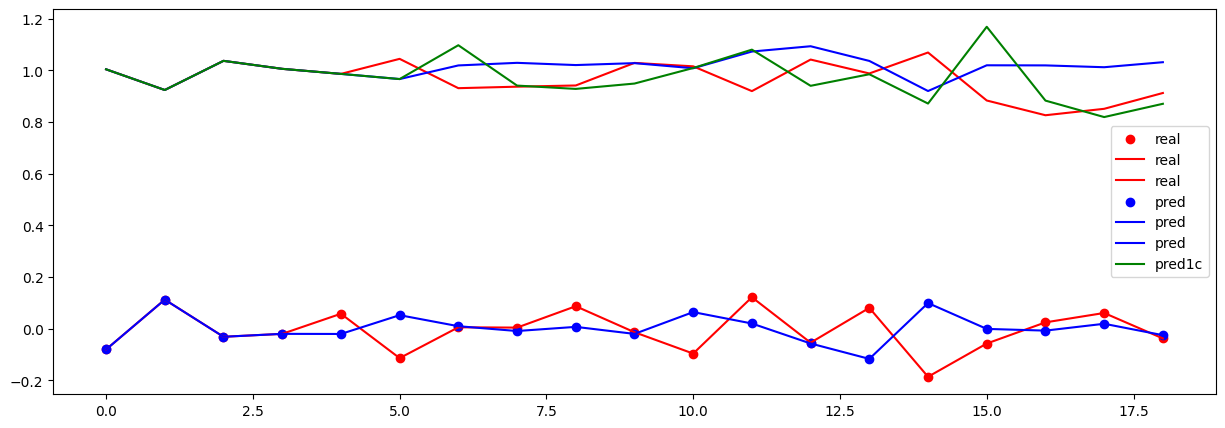

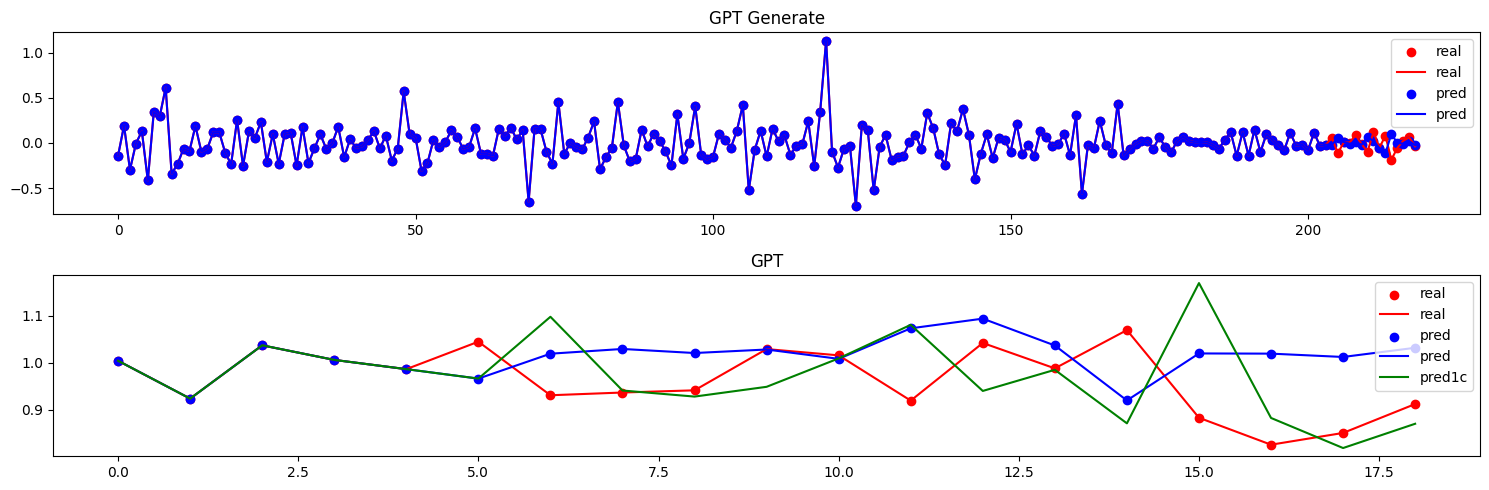

In [107]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([300, 25])
0 train loss =  1.3477703332901
500 train loss =  0.10435695201158524
1000 train loss =  0.041292455047369
1500 train loss =  0.01890217885375023
2000 train loss =  0.012529579922556877
2500 train loss =  0.009563680738210678


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


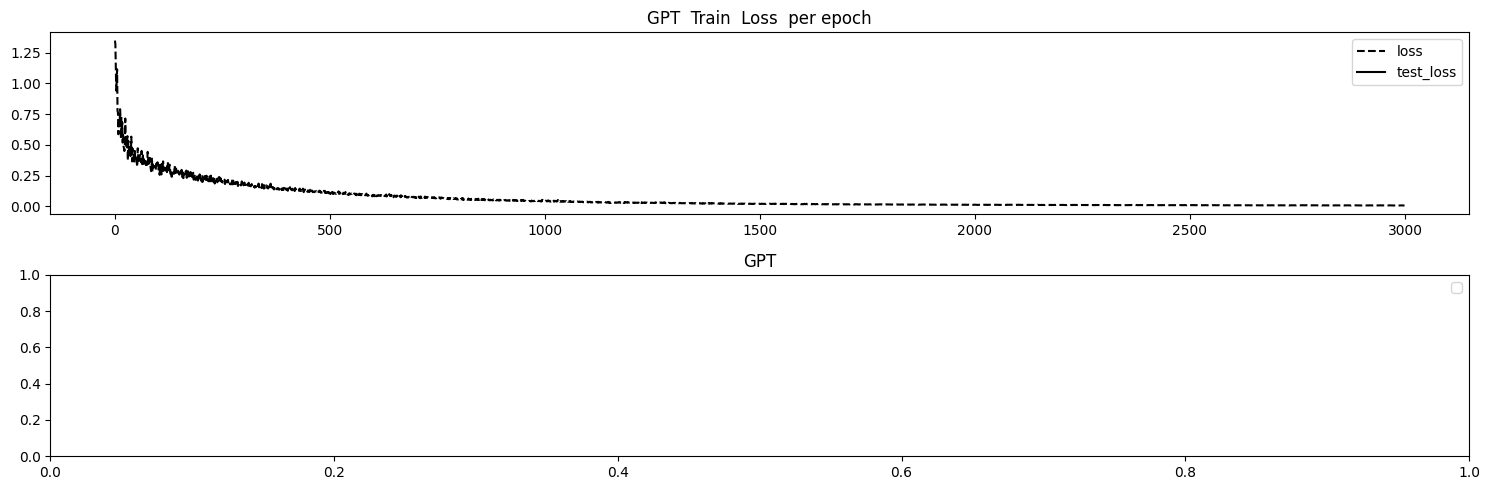

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.010164030827581882
mae, mse, rmse, mape, mspe, rse, corr
(0.08604526, 0.010164032, 0.10081682, 2.06788, 10.4560375, 1.2642858)
Testing R**2 - SI only:  -0.5984184176028098
Testing R**2 - SI only:  -0.5984184176028098
Testing R**2 - All features:  0.9987675219043811


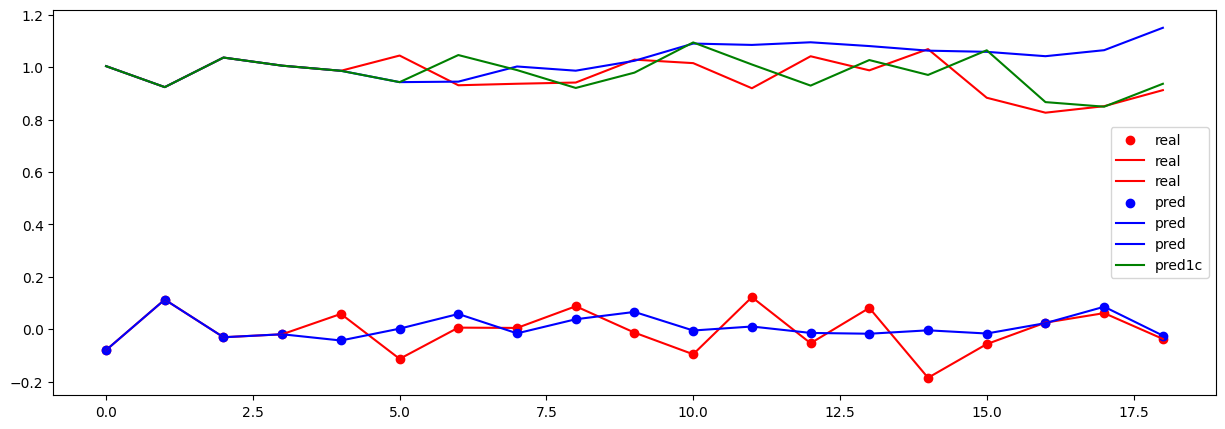

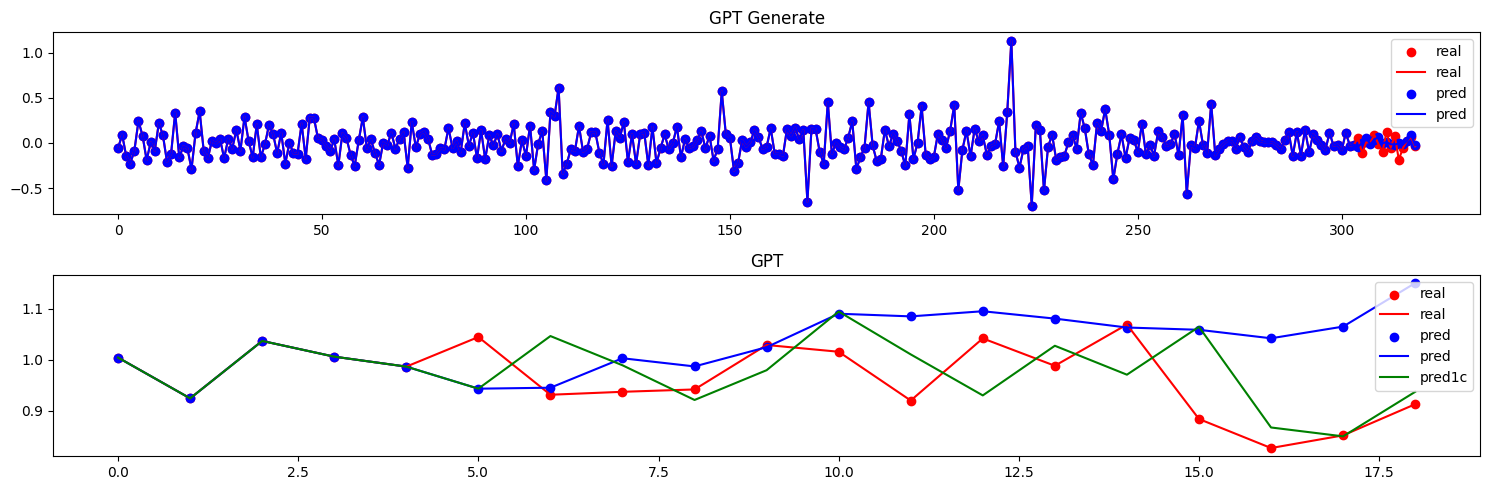

In [108]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([400, 25])
0 train loss =  1.33012855052948
500 train loss =  0.15360404551029205
1000 train loss =  0.05547061190009117
1500 train loss =  0.027374448254704475
2000 train loss =  0.018093936145305634
2500 train loss =  0.01131347380578518


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


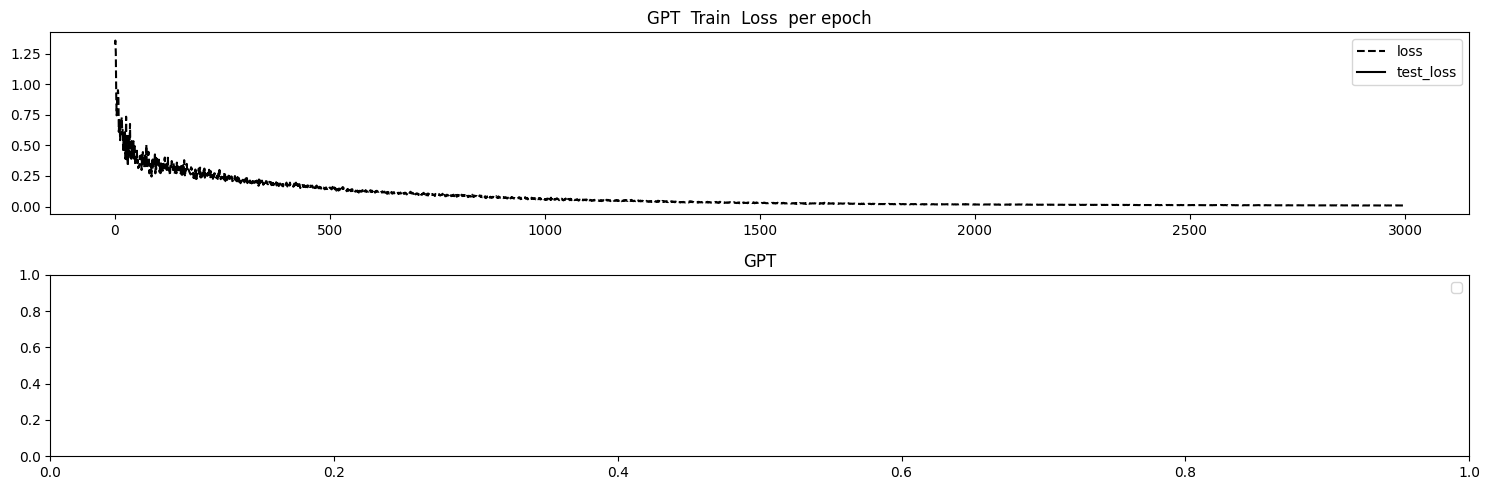

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.009391861967742443
mae, mse, rmse, mape, mspe, rse, corr
(0.07969799, 0.009391863, 0.096911624, 1.5174346, 3.8074024, 1.215313)
Testing R**2 - SI only:  -0.4769853404467903
Testing R**2 - SI only:  -0.4769853404467903
Testing R**2 - All features:  0.9979016924513656


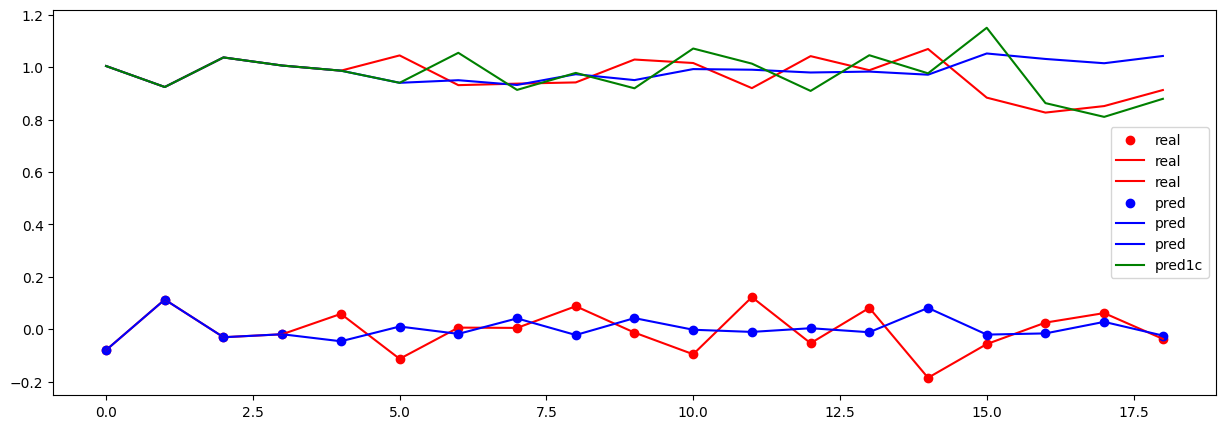

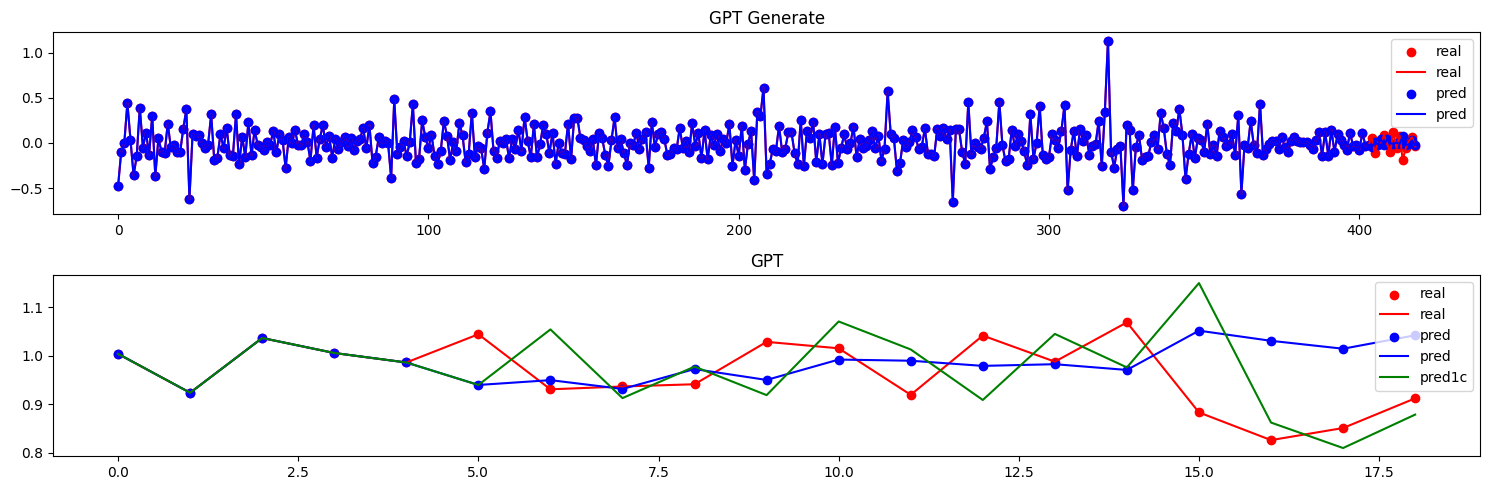

In [109]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
